<a href="https://colab.research.google.com/github/mengyuchi/XML4LULC/blob/main/XML4LULC_Public2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Explainable Machine Learning for Land-Use Land_Cover Classification


# Importing libraries

In [ ]:
_=!pip install rasterio
_=!pip install geopandas

In [ ]:
import tifffile as tif
from PIL import Image
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import geopandas
import ogr, gdal
from copy import deepcopy
import gc
gc.enable()

In [ ]:
import os
os.chdir('/content/drive/MyDrive/LCLU-deep learning')

# Functions

In [ ]:
### 
def mem():
    import resource
    # print('Memory usage         : % 2.2f MB' % round(
    #     resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0,1)
    # )
    return round( resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0,1 )
    
def coord2pixel(ds, xp, yp):
    # unravel GDAL affine transform parameters
    c, a, b, f, d, e = ds.get_transform()
    """Returns global coordinates to pixel center using base-0 raster index"""
    col = int( np.ceil( ( b*yp - e*xp - b*d/2 + e*a/2 - b*f + e*c ) / (b*d - a*e) ) )
    row = int( np.ceil( ( a*yp - d*xp - a*e/2 + d*b/2 - a*f + d*c ) / (a*e - b*d) ) )
    return(row, col)

# #

def shape2tif(Shapefile_path, ref_image_path, OutputImage='shp2tiff.tif'):
    import ogr, gdal
    import subprocess
    # Open Shapefile
    Shapefile = ogr.Open(Shapefile_path)

    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1  # value for the output image pixels
    # Get projection info from reference image
    Shapefile_layer = Shapefile.GetLayer()
    Image = gdal.Open(ref_image_path, gdal.GA_ReadOnly)
    # Rasterise
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(OutputImage, Image.RasterXSize, Image.RasterYSize, 1, datatype,
                                                     options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform())
    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])
    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None
    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE " + OutputImage + " 2 4 8 16 32 64", shell=True)

# #

def generate_raster_GT(ref_image_path, GT_shapefile_path_mask, GT_shapefile_path_2, OutputImage_name='GT_image.tif'):
  import rasterio
  from rasterio.mask import mask
  import geopandas as gpd
  from shapely.geometry import mapping

  # Generate binary tiff from shapefile
  shape2tif(GT_shapefile_path_mask, ref_image_path, OutputImage='shp2tiff.tif')
  OutputImage='shp2tiff.tif'
  GT = rasterio.open(OutputImage).read(1)
  # extract the geometry in GeoJSON format
  shapefile = gpd.read_file(GT_shapefile_path_2)

  shapefile.set_crs(epsg=32633, inplace=True, allow_override=True)
  shapefile.to_crs(epsg=32633)

  geoms = shapefile.geometry.values # list of polygons

  # classes =shapefile.Class.values # polygons' class
  classes = shapefile.fclass.values # polygons' class
  # classes =shapefile.Id.values # polygons' class
  # classes =shapefile.fid.values # polygons' class
  # classes =shapefile.DN.values # polygons' class

  labels_name = np.unique(classes) # unique labels

  # colorizing the tiff_binary_shapefile
  print( 'Number of Polygons: ', len(geoms))

  for ii in range( 0, len(geoms) ):
    polygon = [mapping(geoms[ii])]
    # extract the raster values within the polygon 
    with rasterio.open(OutputImage) as src:
        out_image, out_transform = mask(src, polygon, crop=True)
        label_number = np.where( labels_name == classes[ii] )[0][0]+1
        # print('label: ',label_number)
        # Pixel2Coord (in the cropped image)
        a, b, c, d, e, f = out_transform[0], out_transform[1], out_transform[2], out_transform[3], out_transform[4], out_transform[5]
        """Returns global coordinates to pixel edge using base-0 raster index"""
        col1=0;row1=0
        xp_topleft = a * col1 + b * row1 + a * 0.0 + b * 0.5 + c
        yp_topleft = d * col1 + e * row1 + d * 0.5 + e *0.0 + f # a, e: cell ground size in X and Y directions
        col2=out_image.shape[2]-1;row2=out_image.shape[1]-1
        xp_bottomright = a * col2 + b * row2 + a * 0.0 + b * 0.5 + c
        yp_bottomright = d * col2 + e * row2 + d * 0.5 + e *0.0 + f # a, e: cell ground size in X and Y directions

        # Coord2pixel (in the main image)
        r_topleft, c_topleft = coord2pixel(src, xp_topleft, yp_topleft)
        r_bottomright, c_bottomright = coord2pixel(src, xp_bottomright, yp_bottomright)
        # print('area: ',r_topleft,r_bottomright,c_topleft, c_bottomright)

        # colorizing
        GT[r_topleft:r_bottomright+1, c_topleft:c_bottomright+1]+=(label_number-1)*out_image[0]
  # For deleting a file:
  import os
  os.remove(OutputImage)
  
  return GT

# # 

def tr_te_sample( gt_1d, tr_samples, val_samples, mode='tr' ): # mode = 'tr' or 'val'
  np.random.seed(1)
  tr_idx = []; te_idx = []; val_idx = []
  tr_label = []; te_label = []; val_label = []
  for ii in range(1, max(gt_1d)+1):
    L = np.where(gt_1d==ii)[0]
    np.random.shuffle(L)
    if tr_samples>1:
      samples = deepcopy(tr_samples)
    else:
      samples = int( tr_samples*len(L) )
      
    v_samples = deepcopy(val_samples)

    tr_idx.append(L[:samples])
    val_idx.append(L[samples:samples+v_samples])
    te_idx.append(L[samples+v_samples:])
    #
    tr_label.append( ii*np.ones( len(L[:samples]) ) )
    val_label.append( ii*np.ones( len(L[samples:samples+v_samples]) ) ) 
    te_label.append( ii*np.ones( len(L[samples+v_samples:]) ) ) 
  #
  tr_label=np.uint8( np.hstack(tr_label) )
  val_label=np.uint8( np.hstack(val_label) )
  te_label=np.uint8( np.hstack(te_label) )
  #
  tr_idx=np.uint32( np.hstack(tr_idx) )
  val_idx=np.uint32( np.hstack(val_idx) )
  te_idx=np.uint32( np.hstack(te_idx) )
  #
  idx = np.arange(0, len(tr_label), 1); np.random.shuffle(idx)
  tr_label=tr_label[idx]; tr_idx=tr_idx[idx]
  #
  idx = np.arange(0, len(val_label), 1); np.random.shuffle(idx)
  val_label=val_label[idx]; val_idx=val_idx[idx]
  #
  idx = np.arange(0, len(te_label), 1); np.random.shuffle(idx)
  te_label=te_label[idx]; te_idx=te_idx[idx]

  return tr_label, val_label, te_label, tr_idx, val_idx, te_idx

# # 

def two_d (cube):
    d1, d2, d3 = cube.shape
    im_2d = np.reshape(np.ravel(cube, order='F'), (d1*d2, d3),order=1)
    # col  1 of band 1    col  1 of band 2     ...............     ...............    col  1 of band d3
    # col  2 of band 1    col  2 of band 2     ...............     ...............    col  2 of band d3
    # ................    ................     ...............     ...............    .................
    # ................    ................     ...............     ...............    .................
    # col d2 of band 1    col d2 of band 2     ...............     ...............    col d2 of band d3
    return im_2d

# #
# Normalize to [0, 1]
def normalize(im_2d):  # Map features value to [0, 1]
    d12, d3 = im_2d.shape
    band_max = np.max(im_2d, axis=0) * np.ones((d12, d3))  # maximum radiance in every band
    band_min = np.min(im_2d, axis=0) * np.ones((d12, d3))  # minimum radiance in every band

    #norm_2d = 2*(im_2d-band_max)/(band_max-band_min) + np.ones((d12, d3))  # norm = 2 * ( [x-max]/[max-min] ) +1
    norm_2d = np.float16((im_2d-band_min)/(band_max-band_min))  # norm =  [x-min]/[max-min] 
    return norm_2d

In [ ]:
def confusion_mat(label, predicted, axlabels, plot=True,cmap="gray_r"):
    #OA
    from sklearn.metrics import classification_report, confusion_matrix
    conf_mat = np.float32(confusion_matrix(label, predicted)) 
    OA = 100*np.trace(conf_mat)/len(predicted)
    print('Data Overall Accuracy: ', OA)
    #Kappa
    from sklearn.metrics import cohen_kappa_score
    Kappa = 100*cohen_kappa_score(label, predicted)
    print('Kappa score: ', Kappa)
    from sklearn.metrics import balanced_accuracy_score
    bal_OA = 100*balanced_accuracy_score(label, predicted)
    print('Data Balanced Overall Accuracy: ', bal_OA)
    #Normalized Confusion Mat: Recall
    conf_mat_re=100*conf_mat/np.expand_dims(np.sum(conf_mat,axis=1),1)
    #Normalized Confusion Mat: Precision
    conf_mat_pr=100*conf_mat/np.expand_dims(np.sum(conf_mat,axis=0),1)
    OPr = np.mean(np.diag(conf_mat_pr))
    print('Overall Precision: ', OPr)
    #Normalized Confusion Mat: f1-score
    conf_mat_f1=2*conf_mat_pr*conf_mat_re/(conf_mat_pr+conf_mat_re)
    OF1 = np.mean(np.diag(conf_mat_f1))
    print('Overall F1: ', OF1)
    # conf_mat_f1=(conf_mat/np.expand_dims(np.sum(conf_mat,axis=1),1)+conf_mat/np.expand_dims(np.sum(conf_mat,axis=0),1))/2
    conf_mat_f1[np.isnan(conf_mat_f1)==True]=0
    #Heat Map
    import seaborn as sn
    import pandas  as pd
    if plot==True:
      plt.figure(figsize = (15, 15.45), dpi=100, facecolor='w', edgecolor='k')
      plt.rcParams["font.family"] = "Times New Roman"
      # cmap = sn.cubehelix_palette(start=2, rot=0, dark=0, light=.9, reverse=True, as_cmap=True)
      # cmap="gray_r"
      # cmap="Greens"
      #1
      plt.subplot(2,2,1);plt.title('Confusion matrix: OA='+format( OA, '.4f' )+'; K='+format( Kappa, '.4f' ), fontsize=14)
      sn.set(font_scale=1)#for label size
      # Annotation
      annots = []
      for ii in range(len(axlabels)):
        annots.append([])
        for jj in range(len(axlabels)):
          if conf_mat[ii,jj]<50:
            annots[-1] += ['']
          else:
            annots[-1] += [str(int(conf_mat[ii,jj]))]
      #
      axlabels_num = []
      for numx in range(1,len(axlabels)+1):
        axlabels_num+=[str(numx)]
      ax=sn.heatmap(conf_mat, annot=np.array(annots),annot_kws={"size": 12}, cbar=False, xticklabels=axlabels_num,# linecolor='gray', # 
                 yticklabels=axlabels, cmap=cmap, fmt = '',linewidths=.0)# font size
      ax.set(xlabel='Predicted', ylabel='Actual');
      ax.axis('equal')
      # Frame
      lw=1
      ax.axhline(y=0, color='k',linewidth=lw)
      ax.axhline(y=len(axlabels), color='k',linewidth=lw)
      ax.axvline(x=0, color='k',linewidth=lw)
      ax.axvline(x=len(axlabels), color='k',linewidth=lw)
      #2
      plt.subplot(2,2,2);plt.title('F1: AF1='+format( OF1, '.4f' ), fontsize=14)
      sn.set(font_scale=1)#for label size
      # Annotation
      annots = []
      for ii in range(len(axlabels)):
        annots.append([])
        for jj in range(len(axlabels)):
          if conf_mat_f1[ii,jj]<1:
            annots[-1] += ['']
          else:
            annots[-1] += [format( conf_mat_f1[ii,jj], '.2f' )]
      #
      ax=sn.heatmap(conf_mat_f1, annot=np.array(annots),annot_kws={"size": 12}, cbar=False, xticklabels=axlabels_num, yticklabels=axlabels_num, 
                    cmap=cmap, vmin=0, vmax=100, fmt = '',linewidths=.0)# font size
      ax.axis('equal')
      # Frame
      ax.axhline(y=0, color='k',linewidth=lw)
      ax.axhline(y=len(axlabels), color='k',linewidth=lw)
      ax.axvline(x=0, color='k',linewidth=lw)
      ax.axvline(x=len(axlabels), color='k',linewidth=lw)
      #3
      plt.subplot(2,2,3);plt.title('Recall (Normalized CM): AA='+format( bal_OA, '.4f' ), fontsize=14)
      sn.set(font_scale=1)#for label size
      # Annotation
      annots = []
      for ii in range(len(axlabels)):
        annots.append([])
        for jj in range(len(axlabels)):
          if conf_mat_re[ii,jj]<1:
            annots[-1] += ['']
          else:
            annots[-1] += [format( conf_mat_re[ii,jj], '.2f' )]
      #
      ax=sn.heatmap(conf_mat_re, annot=np.array(annots),annot_kws={"size": 12}, cbar=False, xticklabels=axlabels_num, yticklabels=axlabels_num,
                    cmap=cmap, vmin=0, vmax=100, fmt = '',linewidths=.0)# font size
      ax.axis('equal')
      # Frame
      ax.axhline(y=0, color='k',linewidth=lw)
      ax.axhline(y=len(axlabels), color='k',linewidth=lw)
      ax.axvline(x=0, color='k',linewidth=lw)
      ax.axvline(x=len(axlabels), color='k',linewidth=lw)
      #4
      plt.subplot(2,2,4);plt.title('Precision: APr='+format( OPr, '.4f' ), fontsize=14)
      sn.set(font_scale=1)#for label size
      # Annotation
      annots = []
      for ii in range(len(axlabels)):
        annots.append([])
        for jj in range(len(axlabels)):
          if conf_mat_pr[ii,jj]<1:
            annots[-1] += ['']
          else:
            annots[-1] += [format( conf_mat_pr[ii,jj], '.2f' )]
      #
      ax=sn.heatmap(conf_mat_pr, annot=np.array(annots),annot_kws={"size": 12}, cbar=False, xticklabels=axlabels_num, yticklabels=axlabels_num, 
                    cmap=cmap, vmin=0, vmax=100, fmt = '',linewidths=.0)# font size
      ax.axis('equal')
      # Frame
      ax.axhline(y=0, color='k',linewidth=lw)
      ax.axhline(y=len(axlabels), color='k',linewidth=lw)
      ax.axvline(x=0, color='k',linewidth=lw)
      ax.axvline(x=len(axlabels), color='k',linewidth=lw)
      plt.show()
    #Other Evaluation Metrics
    print('Data Evaluation:')
    print(classification_report(label, predicted)) 
    
    df = pd.DataFrame(data=[OA, Kappa, bal_OA, OPr, OF1],    # values
                              index=['OA', 'Kappa', 'BA', 'Pr', 'F1'],    # 1st column as index
                              columns=['Results'])  # 1st row as the column names
    display(df)

    return conf_mat

# Loading the Data

### Ground truth

In [ ]:
LC_io = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/trainingData/T33UUB_NMD_Reclassed_2018_new.tif')
LC = np.float32( LC_io.read(1) )

# 11 labels
axlabels = ['Agriculture','Coniferous Trees','Deciduous Trees','Mixed Forest',
            'Vegetated Open Land','NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

In [ ]:
LC[LC == 0] = np.nan

In [ ]:
# Removing mixed forest class (it has very few samples!)
LC[LC==4]=np.nan
LC[LC>3] -= 1


# 10 labels
axlabels = ['Agriculture','Coniferous Trees','Deciduous Trees','Vegetated Open Land','NonVegetated Open Land',
            'Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

gc.collect()
np.unique(LC)[:11]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., nan],
      dtype=float32)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Cmaplist = [(253/255,133/255,19/255,1),(1/255,58/255,11/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),
            (213/255,238/255,178/255,1),(91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(15,15),dpi=150)
plt.imshow(LC, cmap=cmap)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
import cv2
import numpy as np

kernel = np.ones( (2,2),np.uint8 )

LC2 = np.zeros( np.shape(LC) )
for ii in range( 1, int(np.nanmax(LC))+1 ):
  single_class_layer = np.zeros( np.shape(LC) )
  single_class_layer[LC == ii] = ii
  single_class_layer = cv2.erode( single_class_layer, kernel, iterations = 1 )
  LC2 += single_class_layer
LC2[LC2==0]=np.nan

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Cmaplist = [(253/255,133/255,19/255,1),(1/255,58/255,11/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),
            (213/255,238/255,178/255,1),(91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['Agriculture','Coniferous Trees','Deciduous Trees',#'Mixed Forest',
            'Vegetated Open Land','NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']
cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(15,15),dpi=150)
plt.imshow(LC2, cmap=cmap)
plt.legend(handles=legend_patch, loc='upper left')
mem()

### FullStack Data (Satellite, Topo, Pheno, Veg. indices)

In [ ]:
r1=0
r2=1821
c1=658
c2=2602

In [ ]:
from rasterio.windows import Window 

fullstack_io = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.tif')

# fullstack=fullstack_io.read( window=Window.from_slices((r1, r2), (c1, c2)) )#clip
# # transpose
# fullstack=np.transpose(fullstack,(1,2,0))
# # normalize
# fullstack -= np.min(fullstack,axis=(0,1))
# fullstack /= np.max(fullstack,axis=(0,1))

# fullstack=np.float16( fullstack )


fullstack = np.load('/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/fullStack_float16_normalized.npy')

gc.collect()
mem()

805.5

In [ ]:
# 2d array
dime = np.shape(fullstack)
# fullstack_2d = np.float16( np.reshape( np.ravel(fullstack, order='F'), (dime[0]*dime[1], dime[2]), order='F' ) )
fullstack_2d = np.reshape( np.ravel(fullstack, order='F'), (dime[0]*dime[1], dime[2]), order='F' )
gc.collect()

44

In [ ]:
# Layers' Visualization
layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)

fig = plt.subplots(figsize=(20, 20),dpi=400)
plt.subplots_adjust(hspace=.3)

subplot_r = 8
subplot_c = 8

ax=[]
mask = LC+0
mask[mask>1]=1
for ii in range(fullstack.shape[2]):
    ax.append( plt.subplot(subplot_r, subplot_c, ii+1) )
    layer_ii = mask*fullstack[:,:,ii]
    # layer_ii[layer_ii==0] = np.nan
    plt.imshow(layer_ii, cmap='jet');plt.title( str(ii+1)+' - '+layers_name[ii][1:-1] )#; plt.grid(True)
    plt.axis('off')

In [ ]:
''' Displaying the RGB '''
dispp = np.float32( np.stack( [fullstack[:,:,32],
                               fullstack[:,:,31],
                               fullstack[:,:,30]], axis=2 ) )
meandisp = np.mean(dispp,axis=(0,1))
stdisp = np.std(dispp,axis=(0,1))
dispp = (dispp-meandisp)/(5*stdisp)
dispp[dispp>1]=1
dispp[dispp<-1]=-1
dispp +=1
dispp /=2

fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(10,10),dpi=100)
ax.imshow(dispp);plt.axis(False)
# plt.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/RGB.jpg', dpi=600)

In [ ]:
fullstack_io = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.tif')

fullstack_notnorm=fullstack_io.read( window=Window.from_slices((r1, r2), (c1, c2)) )#clip
# transpose
fullstack_notnorm=np.transpose(fullstack_notnorm,(1,2,0))

In [ ]:
''' Displaying the Pheno(EOS-End of Season) '''
mask = LC+0
mask[mask>1]=1
dispp = np.float32(mask*fullstack_notnorm[:,:,45])
dispp[dispp>1e+30] = np.nan
dispp[dispp<-1e+38]= np.nan
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(13,10),dpi=300)
ax.imshow(dispp,cmap='jet');plt.axis(False)
# plt.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/Pheno_End of Season_Jet.jpg', dpi=600)

In [ ]:
''' Displaying the Topography '''

mask = LC+0
mask[mask>1]=1
dispp = np.float32(mask*fullstack_notnorm[:,:,46])

plt.figure(figsize=(13,10),dpi=300)
plt.imshow(dispp,cmap='jet');plt.axis(False);# plt.colorbar(label='Elevation (m)')
# plt.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/DEM_Jet.jpg', dpi=600)

In [ ]:
''' Displaying the NDVI '''
mask = LC+0
mask[mask>1]=1
dispp = np.float32(mask*fullstack_notnorm[:,:,55])

fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(15,8),dpi=300)
ax.imshow(dispp,cmap='jet');plt.axis(False)
plt.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/NDVI_Jet.jpg', dpi=600)

In [ ]:
# Layers' Visualization
layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)

fig = plt.subplots(figsize=(20, 20),dpi=400)
plt.subplots_adjust(hspace=.3)

subplot_r = 8
subplot_c = 8

ax=[]
mask = LC2+0
mask[mask>1]=1
for ii in range(fullstack.shape[2]):
    ax.append( plt.subplot(subplot_r, subplot_c, ii+1) )
    layer_ii = mask*fullstack[:,:,ii]
    # layer_ii[layer_ii==0] = np.nan
    plt.imshow(layer_ii, cmap='jet');plt.title( str(ii+1)+' - '+layers_name[ii][1:-1] )#; plt.grid(True)
    plt.axis('off')

In [ ]:
# Layers' Visualization
layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)

fig = plt.subplots(figsize=(25, 25),dpi=200)
plt.subplots_adjust(hspace=.3)

subplot_r = 8
subplot_c = 8

ax=[]
mask = LC2+0
mask[mask>1]=1
for ii in range(fullstack.shape[2]):
    ax.append( plt.subplot(subplot_r, subplot_c, ii+1) )
    hist = mask*fullstack[:,:,ii]
    hist=hist[np.isnan(hist)==False]
    plt.hist(hist, bins=100);plt.title( str(ii+1)+' - '+layers_name[ii][1:-1] )#; plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # plt.axis('off')

### IndividualStacks Folder (GLCM)

In [ ]:
from rasterio.windows import Window # Window(col_off, row_off, width, height)
GLCM_io = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.tif')
GLCM = np.load('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM__float16_normalized_COR&ENT.npy')

gc.collect()
mem()

3412.3

In [ ]:
# 2d array
dime = np.shape(GLCM)
GLCM_2d = np.reshape( np.ravel(GLCM, order='F'), (dime[0]*dime[1], dime[2]), order='F' )
gc.collect()

44

In [ ]:
# GLCM Layers' Visualization
layers_name = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)

fig = plt.subplots(figsize=(25, 35), dpi=500)
plt.subplots_adjust(hspace=.5, wspace=.3)

subplot_r = 16
subplot_c = 10

ax=[]
mask = LC2+0
mask[mask>1]=1
for ii in range(GLCM.shape[2]):
    ax.append( plt.subplot(subplot_r, subplot_c, ii+1) )
    hist = mask*GLCM[:,:,ii]
    hist=hist[np.isnan(hist)==False]
    plt.hist(hist, bins=100);plt.title( str(ii+1)+' - '+layers_name[ii][1:-1],{'fontsize':8} )#; plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    # plt.axis('off')

In [ ]:
# GLCM Layers' Visualization
layers_name = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)

fig = plt.subplots(figsize=(25, 35), dpi=200)
plt.subplots_adjust(hspace=.3)

subplot_r = 16
subplot_c = 10

ax=[]
mask = LC2+0
mask[mask>1]=1
for ii in range(GLCM.shape[2]):
    ax.append( plt.subplot(subplot_r, subplot_c, ii+1) )
    layer_ii = mask*GLCM[:,:,ii]
    # GLCM[ii][GLCM[ii]==np.min(GLCM)]=np.nanmean( GLCM[ii][GLCM[ii]!=np.nanmin(GLCM[ii])] )
    plt.imshow( np.float32(layer_ii), cmap='jet' );plt.title( str(ii+1)+' - '+layers_name[ii][1:-1] )#; plt.grid(True)
    gc.collect()
    plt.axis('off')

# Split Test and Train samples

In [ ]:
gt_1d0 = np.int32( np.ravel(LC, order='F') ); gt_1d0[gt_1d0<1]=0
gt_1d = np.int32( np.ravel(LC2, order='F') ); gt_1d[gt_1d<1]=0

In [ ]:
tr_samples=1000
# tr_samples=.20
val_samples=10000
tr_label, val_label, _, tr_idx, val_idx, _ = tr_te_sample( gt_1d, tr_samples, val_samples )

print('Training samples: ', str(len(tr_idx)))
print('Validation samples: ', str(len(val_idx)))
gc.collect()

Training samples:  10000
Validation samples:  85751


278

#### Removing some classes

In [ ]:
# Omitting label 2 and 4: Coniferous Trees and Non-vegetated lands
tr_idx = np.delete( tr_idx, np.where(tr_label==2) )
val_idx = np.delete( val_idx, np.where(val_label==2) )
tr_label = np.delete( tr_label, np.where(tr_label==2) )
val_label = np.delete( val_label, np.where(val_label==2) )
gt_1d[gt_1d==2]=0
gt_1d0[gt_1d0==2]=0

tr_idx = np.delete( tr_idx, np.where(tr_label==4) )
val_idx = np.delete( val_idx, np.where(val_label==4) )
tr_label = np.delete( tr_label, np.where(tr_label==4) )
val_label = np.delete( val_label, np.where(val_label==4) )
gt_1d[gt_1d==4]=0
gt_1d0[gt_1d0==4]=0

tr_label[ np.logical_and(tr_label>2, tr_label<4) ] -= 1
val_label[ np.logical_and(val_label>2, val_label<4) ] -= 1
gt_1d[ np.logical_and(gt_1d>2, gt_1d<4) ] -= 1
gt_1d0[ np.logical_and(gt_1d0>2, gt_1d0<4) ] -= 1

tr_label[tr_label>4] -= 2
val_label[val_label>4] -= 2
gt_1d[gt_1d>4] -= 2
gt_1d0[gt_1d0>4] -= 2

np.unique(tr_label)

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

# Pre-processing

In [ ]:
train = fullstack_2d[tr_idx]
validation = fullstack_2d[val_idx]
gc.collect()

88

# Random Forest

In [ ]:
# RF
"""CLASSIFIER"""
from sklearn.ensemble import RandomForestClassifier

classifier_RF = RandomForestClassifier(n_estimators=500,max_depth=None)
# classifier_RF.fit(train, tr_label)

#### Scenarios (choose between 1-17)

In [ ]:
scenario = 17

In [ ]:
# For different layers (scenarios)
from sklearn.ensemble import RandomForestClassifier

if scenario == 1:
  # 1 - Just Sentinel temporal: 1-40
  classifier_RF = RandomForestClassifier(n_estimators=600,max_depth=60)
  classifier_RF.fit( train[:,:40], tr_label )

if scenario == 2:
  # 2 - Just Sentinel temporal & Pheno: 1-46
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( train[:,:46], tr_label )
  
if scenario == 3:
  # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,46:49]] ) , tr_label)
  
if scenario == 4:
  # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,49:]] ) , tr_label)
  
if scenario == 5:
  # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( train[:,:49], tr_label )
  
if scenario == 6:
  # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:46], train[:,49:]] ), tr_label )
  
if scenario == 7:
  # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 46-61
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,46:]] ), tr_label )

if scenario == 8:
  # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( train, tr_label )




In [ ]:
# GLCM Scenarios
from sklearn.ensemble import RandomForestClassifier

if scenario == 9:
  # 9 - Just GLCM
  classifier_RF = RandomForestClassifier(n_estimators=600,max_depth=60)
  classifier_RF.fit( GLCM_2d[tr_idx], tr_label )

if scenario == 10:
  # 10 - GLCM + Multi-temporal and Spectral
  classifier_RF = RandomForestClassifier(n_estimators=600,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ), tr_label )

if scenario == 11:
  # 11 - GLCM + Multi-temporal, Spectral, and Phenology
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ), tr_label )
  
if scenario == 12:
  # 12 - GLCM + Multi-temporal, Spectral, and Topography
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ) , tr_label)
  
if scenario == 13:
  # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ) , tr_label)
  
if scenario == 14:
  # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ), tr_label )
  
if scenario == 15:
  # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ), tr_label )
  
if scenario == 16:
  # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ), tr_label )

if scenario == 17:
  # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
  classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
  classifier_RF.fit( np.hstack( [train, GLCM_2d[tr_idx]] ), tr_label )


In [ ]:
# Prediction
ytr_pred = classifier_RF.predict(train)
yval_pred = classifier_RF.predict(validation)

In [ ]:
# Prediction for different layers of fullstack data (scenarios)

if scenario == 1:
  # 1 - Just Sentinel temporal: 1-40
  ytr_pred = classifier_RF.predict(train[:,:40])
  yval_pred = classifier_RF.predict(validation[:,:40])

if scenario == 2:
  # 2 - Just Sentinel temporal & Pheno: 1-46
  ytr_pred = classifier_RF.predict(train[:,:46])
  yval_pred = classifier_RF.predict(validation[:,:46])

if scenario == 3:
  # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
  ytr_pred = classifier_RF.predict(np.hstack( [train[:,:40], train[:,46:49]] ))
  yval_pred = classifier_RF.predict(np.hstack( [validation[:,:40], validation[:,46:49]] ))

if scenario == 4:
  # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
  ytr_pred = classifier_RF.predict(np.hstack( [train[:,:40], train[:,49:]] ))
  yval_pred = classifier_RF.predict(np.hstack( [validation[:,:40], validation[:,49:]] ))

if scenario == 5:
  # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
  ytr_pred = classifier_RF.predict(train[:,:49])
  yval_pred = classifier_RF.predict(validation[:,:49])

if scenario == 6:
  # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:46], train[:,49:]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:46], validation[:,49:]] ) )

if scenario == 7:
  # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
  ytr_pred = classifier_RF.predict(np.hstack( [train[:,:40], train[:,46:]] ))
  yval_pred = classifier_RF.predict(np.hstack( [validation[:,:40], validation[:,46:]] ))

if scenario == 8:
  # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
  ytr_pred = classifier_RF.predict(train)
  yval_pred = classifier_RF.predict(validation)



# GLCM Scenarios

if scenario == 9:
  # 9 - Just GLCM
  ytr_pred = classifier_RF.predict( GLCM_2d[tr_idx] )
  yval_pred = classifier_RF.predict( GLCM_2d[val_idx] )

if scenario == 10:
  # 10 - GLCM + Multi-temporal and Spectral
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:40], GLCM_2d[val_idx]] ) )

if scenario == 11:
  # 11 - GLCM + Multi-temporal, Spectral, and Phenology
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:46], GLCM_2d[val_idx]] ) )
  
if scenario == 12:
  # 12 - GLCM + Multi-temporal, Spectral, and Topography
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:40], validation[:,46:49], GLCM_2d[val_idx]] ) )
  
if scenario == 13:
  # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:40], validation[:,49:], GLCM_2d[val_idx]] ) )
  
if scenario == 14:
  # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:49], GLCM_2d[val_idx]] ) )
  
if scenario == 15:
  # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:46], validation[:,49:], GLCM_2d[val_idx]] ) )
  
if scenario == 16:
  # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
  ytr_pred = classifier_RF.predict( np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation[:,:40], validation[:,46:], GLCM_2d[val_idx]] ) )

if scenario == 17:
  # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
  ytr_pred = classifier_RF.predict( np.hstack( [train, GLCM_2d[tr_idx]] ) )
  yval_pred = classifier_RF.predict( np.hstack( [validation, GLCM_2d[val_idx]] ) )

In [ ]:
# Training results

axlabels = ['Agriculture','Deciduous Trees','NonVegetated Open Land','Water','Wetland', 
            'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

CM_tr = confusion_mat(tr_label, ytr_pred, axlabels=axlabels, plot=True,cmap="gray_r")

In [ ]:
# Validation results

axlabels = ['Agriculture','Deciduous Trees','NonVegetated Open Land','Water','Wetland', 
            'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_RF_Scenario '+str(scenario), CM_val)

# XG Boost

In [ ]:
# https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/
# plot learning curve of an xgboost model
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# define the model
classifier_XG = XGBClassifier(n_estimators=400)

# define the datasets to evaluate each iteration
evalset = [(train, tr_label), (validation[:2000,:], val_label[:2000])]
# fit the model
classifier_XG.fit(train, tr_label, eval_metric='mlogloss', early_stopping_rounds=10, eval_set=evalset)
# evaluate performance
yhat = classifier_XG.predict(validation[:2000,:])

# retrieve performance metrics
score = accuracy_score(val_label[:2000], yhat)
print('Accuracy: %.3f' % score)
results = classifier_XG.evals_result()
# plot learning curves
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='validation')
plt.legend(); plt.show()

In [ ]:
# Prediction
ytr_pred = classifier_XG.predict(train)
yval_pred = classifier_XG.predict(validation)

### Scenarios

In [ ]:
SCENARIOS = np.arange(17,18,1)

[0]	validation_0-mlogloss:1.90589
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.77099
[2]	validation_0-mlogloss:1.66262
[3]	validation_0-mlogloss:1.5673
[4]	validation_0-mlogloss:1.4853
[5]	validation_0-mlogloss:1.4131
[6]	validation_0-mlogloss:1.34909
[7]	validation_0-mlogloss:1.29313
[8]	validation_0-mlogloss:1.24286
[9]	validation_0-mlogloss:1.1983
[10]	validation_0-mlogloss:1.15594
[11]	validation_0-mlogloss:1.11745
[12]	validation_0-mlogloss:1.08317
[13]	validation_0-mlogloss:1.05154
[14]	validation_0-mlogloss:1.02298
[15]	validation_0-mlogloss:0.995937
[16]	validation_0-mlogloss:0.970058
[17]	validation_0-mlogloss:0.946209
[18]	validation_0-mlogloss:0.923481
[19]	validation_0-mlogloss:0.901676
[20]	validation_0-mlogloss:0.881699
[21]	validation_0-mlogloss:0.863356
[22]	validation_0-mlogloss:0.846429
[23]	validation_0-mlogloss:0.830685
[24]	validation_0-mlogloss:0.81457
[25]	validation_0-mlogloss:0.800765
[26]	validation_0-mloglos

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


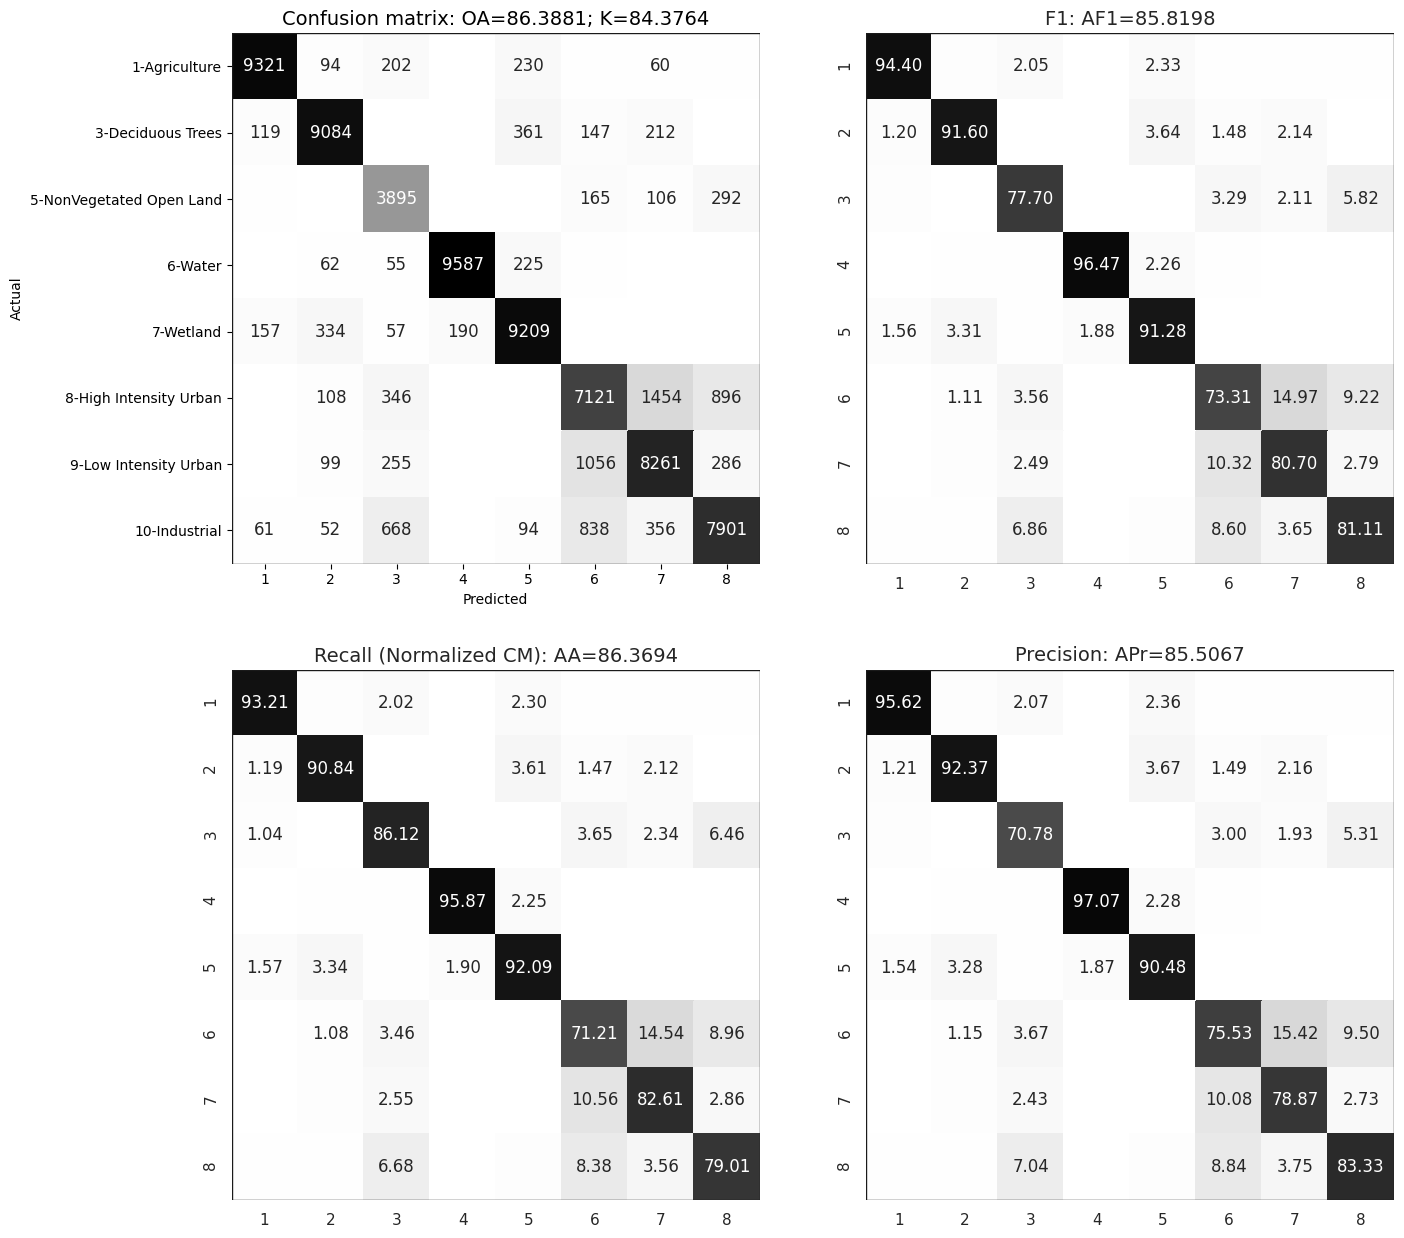

Data Evaluation:
              precision    recall  f1-score   support

           1       0.96      0.93      0.94     10000
           2       0.92      0.91      0.92     10000
           3       0.71      0.86      0.78      4523
           4       0.97      0.96      0.96     10000
           5       0.90      0.92      0.91     10000
           6       0.76      0.71      0.73     10000
           7       0.79      0.83      0.81     10000
           8       0.83      0.79      0.81     10000

    accuracy                           0.86     74523
   macro avg       0.86      0.86      0.86     74523
weighted avg       0.87      0.86      0.86     74523



,Results
OA,86.388095
Kappa,84.376405
BA,86.369426
Pr,85.506737
F1,85.819778


In [ ]:
# For different layers (scenarios)
# https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

for scenario in SCENARIOS:
  '''''''''''''''''''''''''''''''  # define the model '''''''''''''''''''''''''''''''
  classifier_XG = XGBClassifier(n_estimators=400)
  es = 20
  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    evalset = [(train[:,:40], tr_label), (validation[:2000,:40], val_label[:2000])]# define the datasets to evaluate each iteration
    classifier_XG.fit( train[:,:40], tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    evalset = [(train[:,:46], tr_label), (validation[:2000,:46], val_label[:2000])]# define the datasets to evaluate each iteration
    classifier_XG.fit( train[:,:46], tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    evalset = [(np.hstack( [train[:,:40], train[:,46:49]] ), tr_label), (np.hstack( [validation[:2000,:40], validation[:2000,46:49]] ), val_label[:2000])]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,46:49]] ) , tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    evalset = [ (np.hstack( [train[:,:40], train[:,49:]] ), tr_label), (np.hstack( [validation[:2000,:40], validation[:2000,49:]] ), val_label[:2000]) ]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,49:]] ) , tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    evalset = [ (train[:,:49], tr_label), (validation[:2000,:49], val_label[:2000]) ]# define the datasets to evaluate each iteration
    classifier_XG.fit( train[:,:49], tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    evalset = [ (np.hstack( [train[:,:46], train[:,49:]] ), tr_label), (np.hstack( [validation[:2000,:46], validation[:2000,49:]] ), val_label[:2000]) ]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:46], train[:,49:]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    evalset = [ (np.hstack( [train[:,:40], train[:,46:]] ), tr_label), (np.hstack( [validation[:2000,:40], validation[:2000,46:]] ), val_label[:2000]) ]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,46:]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    evalset = [(train, tr_label), (validation[:2000], val_label[:2000])]# define the datasets to evaluate each iteration
    classifier_XG.fit( train, tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )





  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    evalset = [( GLCM_2d[val_idx][:2000], val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( GLCM_2d[tr_idx], tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    evalset = [(np.hstack( [validation[:2000,:40], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    evalset = [(np.hstack( [validation[:2000,:46], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    evalset = [(np.hstack( [validation[:2000,:40], validation[:2000,46:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ) , tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    evalset = [(np.hstack( [validation[:2000,:40], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ) , tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    evalset = [(np.hstack( [validation[:2000,:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    evalset = [(np.hstack( [validation[:2000,:46], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )
    
  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    evalset = [(np.hstack( [validation[:2000,:40], validation[:2000,46:], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    evalset = [(np.hstack( [validation[:2000], GLCM_2d[val_idx][:2000]] ), val_label[:2000] )]# define the datasets to evaluate each iteration
    classifier_XG.fit( np.hstack( [train, GLCM_2d[tr_idx]] ), tr_label, eval_metric='mlogloss', early_stopping_rounds=es, eval_set=evalset )


  '''''''''''''''''''# Prediction for different layers of fullstack data (scenarios)'''''''''''''''''''

  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    ytr_pred = classifier_XG.predict(train[:,:40])
    yval_pred = classifier_XG.predict(validation[:,:40])

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    ytr_pred = classifier_XG.predict(train[:,:46])
    yval_pred = classifier_XG.predict(validation[:,:46])

  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    ytr_pred = classifier_XG.predict(np.hstack( [train[:,:40], train[:,46:49]] ))
    yval_pred = classifier_XG.predict(np.hstack( [validation[:,:40], validation[:,46:49]] ))

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    ytr_pred = classifier_XG.predict(np.hstack( [train[:,:40], train[:,49:]] ))
    yval_pred = classifier_XG.predict(np.hstack( [validation[:,:40], validation[:,49:]] ))

  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    ytr_pred = classifier_XG.predict(train[:,:49])
    yval_pred = classifier_XG.predict(validation[:,:49])

  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:46], train[:,49:]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:46], validation[:,49:]] ) )

  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    ytr_pred = classifier_XG.predict(np.hstack( [train[:,:40], train[:,46:]] ))
    yval_pred = classifier_XG.predict(np.hstack( [validation[:,:40], validation[:,46:]] ))

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred = classifier_XG.predict(train)
    yval_pred = classifier_XG.predict(validation)



  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    ytr_pred = classifier_XG.predict( GLCM_2d[tr_idx] )
    yval_pred = classifier_XG.predict( GLCM_2d[val_idx] )

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:40], GLCM_2d[val_idx]] ) )

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:46], GLCM_2d[val_idx]] ) )
    
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:40], validation[:,46:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:40], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:46], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    ytr_pred = classifier_XG.predict( np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation[:,:40], validation[:,46:], GLCM_2d[val_idx]] ) )

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred = classifier_XG.predict( np.hstack( [train, GLCM_2d[tr_idx]] ) )
    yval_pred = classifier_XG.predict( np.hstack( [validation, GLCM_2d[val_idx]] ) )




  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']
  # axlabels = ['1-Agriculture','2-Artificial','3-Coniferous Trees','4-Deciduous Trees','5-Mixed Forest', '6-Vegetated Open Land','7-NonVegetated Open Land','8-Water','9-Wetland']

  print('Scenario: \n', scenario)
  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_XG_Scenario '+str(scenario), CM_val)

# SVM

##### Investigating different scenarios for SVM model

In [ ]:
SCENARIOS=np.arange(1,18,1)

In [ ]:
# For different layers (scenarios)
from sklearn.svm import SVC
from SVM_with_Optimization import SVM_Classifier
import warnings
warnings.filterwarnings("ignore")


C_settings = [1, 10, 7] # [c1, c2, samples between c1 and c2] | c = 10**c1:10**c2
G_settings = [-5, 10, 7] # [gamma1, gamma2, samples between gamma1 and gamma2] | gamma = 10**gamma1:10**gamma2
rounds = 5
svm_kernels = ['rbf']
es = 20


for scenario in SCENARIOS:
  '''''''''''''''''''''''''''''''  # define the model '''''''''''''''''''''''''''''''
  
  # classifier_SVM = SVC(C=c, kernel=Kernel, gamma=gamma, decision_function_shape='ovr', max_iter=50000)
  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:40], tr_label, validation[:2000,:40], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:46], tr_label, validation[:2000,:46], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:49]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:49]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,49:]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,49:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:49], tr_label, validation[:2000,:49], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], train[:,49:]] ), tr_label, np.hstack( [validation[:2000,:46], validation[:2000,49:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train, tr_label, validation[:2000], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(GLCM_2d[tr_idx], tr_label, GLCM_2d[val_idx][:2000], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:46], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
   
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
 
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:46], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train, GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)


  '''''''''''''''''''# Prediction for different layers of fullstack data (scenarios)'''''''''''''''''''

  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    yval_pred = classifier_SVM.predict(validation[:,:40])

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    yval_pred = classifier_SVM.predict(validation[:,:46])

  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,46:49]] ))

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,49:]] ))

  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    yval_pred = classifier_SVM.predict(validation[:,:49])

  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], validation[:,49:]] ) )

  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,46:]] ))

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    yval_pred = classifier_SVM.predict(validation)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    yval_pred = classifier_SVM.predict( GLCM_2d[val_idx] )

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], GLCM_2d[val_idx]] ) )

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], GLCM_2d[val_idx]] ) )
    
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,46:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,46:], GLCM_2d[val_idx]] ) )

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation, GLCM_2d[val_idx]] ) )

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  print('Scenario: \n', scenario)
  print('Model:\n')
  print(classifier_SVM)
  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_SVM_Scenario '+str(scenario), CM_val)

In [ ]:
SCENARIOS = np.arange(9,18,1)

In [ ]:
# For different layers (scenarios)
from sklearn.svm import SVC
from SVM_with_Optimization import SVM_Classifier
import warnings
warnings.filterwarnings("ignore")


C_settings = [1, 10, 7] # [c1, c2, samples between c1 and c2] | c = 10**c1:10**c2
G_settings = [-10, 10, 7] # [gamma1, gamma2, samples between gamma1 and gamma2] | gamma = 10**gamma1:10**gamma2
rounds = 5
svm_kernels = ['rbf']
es = 20


for scenario in SCENARIOS:
  '''''''''''''''''''''''''''''''  # define the model '''''''''''''''''''''''''''''''
  
  # classifier_SVM = SVC(C=c, kernel=Kernel, gamma=gamma, decision_function_shape='ovr', max_iter=50000)
  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:40], tr_label, validation[:2000,:40], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:46], tr_label, validation[:2000,:46], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:49]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:49]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,49:]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,49:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train[:,:49], tr_label, validation[:2000,:49], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], train[:,49:]] ), tr_label, np.hstack( [validation[:2000,:46], validation[:2000,49:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
    
  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(train, tr_label, validation[:2000], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(GLCM_2d[tr_idx], tr_label, GLCM_2d[val_idx][:2000], val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:46], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
   
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:49], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)
 
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,49:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:49], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:49], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:46], train[:,49:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:46], validation[:2000,49:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train[:,:40], train[:,46:], GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000,:40], validation[:2000,46:], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    ytr_pred, yval_pred, classifier_SVM = SVM_Classifier(np.hstack( [train, GLCM_2d[tr_idx]] ), tr_label, np.hstack( [validation[:2000], GLCM_2d[val_idx][:2000]] ), val_label[:2000],
               C_settings, G_settings, rounds, Kernels = svm_kernels, probability = False, es = es)


  '''''''''''''''''''# Prediction for different layers of fullstack data (scenarios)'''''''''''''''''''

  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    yval_pred = classifier_SVM.predict(validation[:,:40])

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    yval_pred = classifier_SVM.predict(validation[:,:46])

  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,46:49]] ))

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,49:]] ))

  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    yval_pred = classifier_SVM.predict(validation[:,:49])

  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], validation[:,49:]] ) )

  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    yval_pred = classifier_SVM.predict(np.hstack( [validation[:,:40], validation[:,46:]] ))

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    yval_pred = classifier_SVM.predict(validation)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    yval_pred = classifier_SVM.predict( GLCM_2d[val_idx] )

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], GLCM_2d[val_idx]] ) )

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], GLCM_2d[val_idx]] ) )
    
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,46:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:49], GLCM_2d[val_idx]] ) )
    
  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:46], validation[:,49:], GLCM_2d[val_idx]] ) )
    
  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation[:,:40], validation[:,46:], GLCM_2d[val_idx]] ) )

  if scenario == 17:
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    yval_pred = classifier_SVM.predict( np.hstack( [validation, GLCM_2d[val_idx]] ) )

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  print('Scenario: \n', scenario)
  print('Model:\n')
  print(classifier_SVM)
  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_SVM_Scenario '+str(scenario), CM_val)

# DEEP LEARNING

### Import deep libraries

In [ ]:
# !pip uninstall tensorflow -y
# !pip install  tensorflow==2.1

In [ ]:
#Add NN Libraries
import tensorflow as tf
import keras
import time
from tensorflow.keras import regularizers
# from keras.layers.convolutional import Conv2D, Conv3D 
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout,Concatenate, LSTM, GRU, SimpleRNN,BatchNormalization,\
 Bidirectional, Reshape, MaxPool2D,AveragePooling3D, MaxPooling3D,MaxPooling2D,TimeDistributed, Conv2D, Conv3D
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.backend import squeeze
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.regularizers import l2
#from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM, GRU, SimpleRNN, Bidirectional, Reshape
# from tensorflow.keras.layers import Dense

from tensorflow.keras.layers import Activation, ReLU, Add
# from keras.layers.convolutional import MaxPooling2D
# from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import plot_model
# from keras_sequential_ascii import sequential_model_to_ascii_printout
from tensorflow.keras import backend as K
#if K.backend()=='tensorflow':
 #   K.set_image_dim_ordering("th")

# K.set_image_data_format('channels_first') # set format
K.set_image_data_format('channels_last') # set format
print(K.image_data_format()) # print current format

channels_last


In [ ]:
tf.__version__

'2.6.0'

In [ ]:
# GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at:{}'.format(device_name))

Found GPU at:/device:GPU:0


In [ ]:
def patchgen (data, idx, p=17, verbose=0):
  #print('Based on gt_1d = GT.flatten ordering!!!')
  zpad = int(p/2)
  #Z = np.zeros([data.shape[0]+2*zpad, data.shape[1]+2*zpad,data.shape[2]])
  #for i in range (data.shape[2]):
  #  Z[:,:,i]=np.pad(data[:,:,i], ((zpad, zpad), (zpad, zpad)), 'constant')
  patch = np.zeros([idx.shape[0],data.shape[2],p,p])
  if verbose ==1:
    #print('Zero Padded data shape:',Z.shape)
    print('patch shape:',patch.shape)
  for i in range(idx.shape[0]):
    # if gt_1d = GT.flatten():
    # c = int(tr_idx[0]%data.shape[1])
    # r = int(tr_idx[0]/data.shape[1])

    # if gt_1d = np.ravel(GT, order='F'):
    r = int(idx[i]%data.shape[0])
    c = int(idx[i]/data.shape[0])

    #print(r,c)
  #1
    if r > int(p/2) and r < int(data.shape[0])-int(p/2) and c > int(p/2) and c < int(data.shape[1])-int(p/2):
      patch[i,:,:,:] = np.transpose(np.expand_dims(data[r-int(p/2):r+int(p/2)+1, c-int(p/2):c+int(p/2)+1,:], axis=0), (0,3,1,2))
  #2
    elif r <= int(p/2) and c <= int(p/2):
      patch[i, :, int(p/2)-r:, int(p/2)-c:] = np.transpose(np.expand_dims(data[:r+int(p/2)+1, :c+int(p/2)+1, :], axis=0), (0,3,1,2))
  #3
    elif r <= int(p/2) and c >= data.shape[1]-int(p/2):
      patch[i, :, int(p/2)-r:,:int(p/2)+data.shape[1]-c] = np.transpose(np.expand_dims(data[:r+int(p/2)+1, c-int(p/2):, :], axis=0), (0,3,1,2))
  #4
    elif r >= data.shape[0]-int(p/2) and c <= int(p/2):
      patch[i, :, :int(p/2)+data.shape[0]-r ,int(p/2)-c:] = np.transpose(np.expand_dims(data[r-int(p/2): ,:int(p/2)+c+1, :], axis=0), (0,3,1,2))
  #5
    elif r >= data.shape[0]-int(p/2) and c >= data.shape[1]-int(p/2):
      patch[i, :, :int(p/2)+data.shape[0]-r ,:int(p/2)+data.shape[1]-c] = np.transpose(np.expand_dims(data[r-int(p/2): ,c-int(p/2):, :], axis=0), (0,3,1,2))
  #6
    elif r <= int(p/2):
      patch[i, :, int(p/2)-r: , :] = np.transpose(np.expand_dims(data[:r+int(p/2)+1 ,c-int(p/2):c+int(p/2)+1, :], axis=0), (0,3,1,2))
  #7
    elif c >= data.shape[1]-int(p/2):
      patch[i, :, :,:int(p/2)+data.shape[1]-c ] = np.transpose(np.expand_dims(data[r-int(p/2):r+int(p/2)+1 ,c-int(p/2):, :], axis=0), (0,3,1,2))
  #8
    elif r >= data.shape[0]-int(p/2):
      patch[i, : , :int(p/2)+data.shape[0]-r, :] = np.transpose(np.expand_dims(data[r-int(p/2):, c-int(p/2):c+int(p/2)+1, :], axis=0), (0,3,1,2))
  #9
    elif c <= int(p/2):
      patch[i, :, :, int(p/2)-c:] = np.transpose(np.expand_dims(data[r-int(p/2):r+int(p/2)+1, :c+int(p/2)+1:, :], axis=0), (0,3,1,2))
    
    #import dask.array as da
    #patch = da.from_array(patch, chunks=(100))
    # gc.collect()
  return np.float16(patch)

In [ ]:
class Custom_BatchData_Generator(tf.keras.utils.Sequence) : # Ben's version
  # https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71
  import tensorflow as tf
  import gc

  '''
  Inputs:
  - Data cube (cube)
  - Patch size (p)
  - samples indices (s_idx)
  - labels
  - mini-Batch size (batch_size)
  '''

  def __init__( self, cube, p, s_idx, labels, batch_size ) :
    self.cube = cube
    self.p = p
    self.s_idx = s_idx
    self.labels = labels
    self.batch_size = batch_size


  def __len__(self) : # number of mini-batches based on the number of the required data patches
    return ( np.ceil(len(self.s_idx) / float(self.batch_size)) ).astype(np.int)
  
  
  def __getitem__(self, idx) :
    patch_idx = self.s_idx[ idx * self.batch_size : (idx+1) * self.batch_size ]
    batch_y = self.labels[ idx * self.batch_size : (idx+1) * self.batch_size ]
    # Channel_last
    batch_x = np.transpose( patchgen ( self.cube, patch_idx, p=self.p, verbose=0 ),(0,2,3,1) )
    # print(batch_x.shape)

    # gc.collect()
    # print('idx: ', idx)
    # print( ' - used memory: ', mem() )
    
    return batch_x, batch_y

p=31
# p=15
# batch_size = 32
# training_batch_generator = Custom_BatchData_Generator( fullstack[:,:,:], p, tr_idx, tr_label, batch_size )

In [ ]:
p=31
# p=15

In [ ]:
train_P=0
validation_P=0
gc.collect()
train_P = patchgen (fullstack[:,:,:], tr_idx, p=p, verbose=1)
validation_P = patchgen (fullstack[:,:,:], val_idx[:2000], p=p, verbose=1)
gc.collect()

# Channel_last
train_P = np.transpose( train_P,(0,2,3,1) )
validation_P = np.transpose( validation_P,(0,2,3,1) )
gc.collect()
mem()

In [ ]:
# One hot encoding
from tensorflow import keras
tr_label_mlp = keras.utils.to_categorical(tr_label-1)
val_label_mlp = keras.utils.to_categorical(val_label-1)

In [ ]:
cube_shape = [p,p,61]

### VGG16

In [ ]:
model_name = 'VGG16'
def VGG16_function():
  from tensorflow.keras import layers, Model, Input
  # https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16
  input = Input(cube_shape, name='input')
  # Reshape
  input2=tf.image.resize(input, size=(64,64), method='bilinear', preserve_aspect_ratio=False)

  # VGG16 without top (FC layers)
  vgg16 = tf.keras.applications.VGG16(
      include_top=False, weights=None, input_tensor=input2, # width and height should not be smaller than 32
      input_shape=None, pooling=None, 
      # classes=8, classifier_activation='softmax'
  )

  flat = Flatten(name = 'Flatten')(vgg16.layers[-1].output)
  
  Output = Dense(np.max(tr_label), activation='softmax',
                #  kernel_regularizer=l2(0.005), activity_regularizer=l2(0.005),
                 name = 'Output')(flat)

  model = Model(inputs=input, outputs=Output)

  return model
model=VGG16_function()

### ResNet50

In [ ]:
model_name = 'ResNet50'
def ResNet50_function(input_shape):
  input = Input(input_shape, name='input')
  # Reshape
  input2=tf.image.resize(input, size=(64,64), method='bilinear', preserve_aspect_ratio=False)

  # res50 without top (FC layers)
  res50 = tf.keras.applications.ResNet50(
      include_top=False, weights=None, input_tensor=input2, # width and height should be no smaller than 32
      input_shape=None, pooling=None, 
      # classes=8, classifier_activation='softmax'
  )

  flat = Flatten(name = 'Flatten')(res50.layers[-1].output)
  #
  #
  # Output = Dense(np.max(gt_1d), activation='linear', kernel_regularizer=l2(0.005), activity_regularizer=l2(0.005),
  #                   # kernel_initializer=initializer,
  #                   name = 'Output')(flat)
  Output = Dense(np.max(tr_label), activation='softmax',
                 kernel_regularizer=l2(0.005), activity_regularizer=l2(0.005),
                 name = 'Output')(flat)

  model = Model(inputs=input, outputs=Output)

  return model
model=ResNet50_function(cube_shape)

In [ ]:
model.summary(line_length=130)


Model: "model"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
input (InputLayer)                        [(None, 31, 31, 40)]         0                                                          
__________________________________________________________________________________________________________________________________
tf.image.resize_2 (TFOpLambda)            (None, 64, 64, 40)           0               input[0][0]                                
__________________________________________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)                 (None, 70, 70, 40)           0               tf.image.resize_2[0][0]                    
____________________________________________________________________

### Simple CNN

In [ ]:
def CONV2D_section(INPUT, layers_num, kernels_num = 64, kernels_shape = (3,3), strides=(1,1), padding='valid', reg=0, Name = ''):
  conv_layer = INPUT
  for ii in range(layers_num):
    conv_layer = Conv2D(kernels_num, kernels_shape, 
                        #padding='same',
                        kernel_regularizer=regularizers.l2(reg),
                        #activity_regularizer=regularizers.l2(reg),
                        activation='relu',
                        strides=strides,
                        padding=padding,
                        name = Name+'_Conv2D'+str(ii))(conv_layer)
    conv_layer = BatchNormalization(name = Name+'_BN'+str(ii))(conv_layer)
    conv_layer = Dropout(0.1, name = Name+'_DO'+str(ii))(conv_layer)
  #
  return conv_layer
  
def simple_CNN(input_shape):
  input = Input(input_shape, name='input')
  layers_num = 1
  CNN = CONV2D_section(input, layers_num, kernels_num = 32, kernels_shape = (3,3), strides=(1,1), padding='valid', reg=0, Name = 'Conv1')
  CNN = MaxPooling2D( (2,2) )(CNN)
  CNN = CONV2D_section(CNN, layers_num, kernels_num = 64, kernels_shape = (3,3), strides=(1,1), padding='valid', reg=0, Name = 'Conv2')
  CNN = MaxPooling2D( (2,2) )(CNN)
  CNN = CONV2D_section(CNN, layers_num, kernels_num = 128, kernels_shape = (3,3), strides=(1,1), padding='valid', reg=0, Name = 'Conv3')
  CNN = MaxPooling2D( (2,2) )(CNN)
  flat = Flatten(name = 'Flatten')(CNN)
  dense = Dense(256,activation='relu',name = 'FC')(flat)
  output = Dense(np.max(tr_label), activation='softmax', name = 'softmax')(dense)

  model = Model(inputs=input, outputs=output)
  return model

model = simple_CNN(cube_shape)
model.summary(line_length=130)

Model: "model"
__________________________________________________________________________________________________________________________________
Layer (type)                                              Output Shape                                        Param #             
input (InputLayer)                                        [(None, 31, 31, 61)]                                0                   
__________________________________________________________________________________________________________________________________
Conv1_Conv2D0 (Conv2D)                                    (None, 29, 29, 32)                                  17600               
__________________________________________________________________________________________________________________________________
Conv1_BN0 (BatchNormalization)                            (None, 29, 29, 32)                                  128                 
____________________________________________________________________

### Hyper Parameters

In [ ]:
mem()
gc.collect()
mem()

1511.9

In [ ]:
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False)
lrate = 0.0007
epochs = 100
sgd = SGD(learning_rate=lrate, #decay=decay, 
          momentum=0.9, nesterov=False)  # sgd optimizer
adam = Adam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, #epsilon=5e-04, 
            #decay=decay,
            amsgrad=False) # Default
adadelta = Adadelta(learning_rate=lrate, rho=0.90, epsilon=None)#, decay=decay)
rmsprop = RMSprop(learning_rate=lrate)

decay = lrate/epochs
nadam = Nadam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, 
            decay=decay
            )

### Train Deep model

In [ ]:
# model = VGG16_function()
# model = ResNet50_function(input_shape=[31,31,61])
model = simple_CNN(input_shape=[31,31,61])
# print(model_name)

# Compile Model
model.compile(loss=loss, 
              # optimizer=adam, 
              optimizer=nadam, 
             #  optimizer=sgd, 
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es_monitor = 'val_accuracy'
es = EarlyStopping(monitor=es_monitor, min_delta=0, mode='auto', verbose=1, patience=20, baseline=None, restore_best_weights=True)
batch = 64 # Vgg16 needs small batch size (for ResNet: 64)
# batch = 48
# lrate = 0.001

import time
tic = time.clock()
Fit_Model = model.fit(
    train_P[:,:,:,:61], tr_label_mlp, validation_data=(validation_P[:,:,:,:61], val_label_mlp[:2000]), 
    # train_P, tr_label, validation_data=(validation_P, val_label[:2000]), 
    epochs=epochs, verbose=1, 
    batch_size=batch,
    callbacks=[es]
     )
toc = time.clock()
print('TIME: ',(toc - tic)/epochs, ' s/epoch')
gc.collect()
mem()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':


Epoch 1/100
13/13 [==============================] - 55s 462ms/step - loss: 7.9117 - accuracy: 0.1750 - val_loss: 2.1705 - val_accuracy: 0.1175
Epoch 2/100
13/13 [==============================] - 2s 194ms/step - loss: 3.9870 - accuracy: 0.3325 - val_loss: 2.1743 - val_accuracy: 0.1250
Epoch 3/100
13/13 [==============================] - 3s 216ms/step - loss: 3.1346 - accuracy: 0.4175 - val_loss: 2.1952 - val_accuracy: 0.1250
Epoch 4/100
13/13 [==============================] - 3s 215ms/step - loss: 2.3020 - accuracy: 0.4913 - val_loss: 2.2464 - val_accuracy: 0.1100
Epoch 5/100
13/13 [==============================] - 2s 195ms/step - loss: 2.2689 - accuracy: 0.6000 - val_loss: 2.2913 - val_accuracy: 0.1235
Epoch 6/100
13/13 [==============================] - 2s 193ms/step - loss: 1.5996 - accuracy: 0.6963 - val_loss: 2.2284 - val_accuracy: 0.1235
Epoch 7/100
13/13 [==============================] - 2s 195ms/step - loss: 1.0331 - accuracy: 0.8413 - val_loss: 2.3940 - val_accuracy: 0.123

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


7401.2

In [ ]:
# Save model

# Path to save weights
weights_path = '/'

import os
if not os.path.exists(weights_path): # check if output folder exists
    os.makedirs(weights_path)

# model.save_weights(weights_path+'/'+model_name+'.h5')
model.save_weights(weights_path+'/LCLU_'+model_name+'.h5')

##### Investigating different scenarios for ResNet50 model

In [ ]:
SCENARIOS=np.arange(1,9,1)
SCENARIOS

array([1, 2, 3, 4, 5, 6, 7, 8])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es_monitor = 'val_accuracy'
es = EarlyStopping(monitor=es_monitor, min_delta=0, mode='auto', verbose=1, patience=20, baseline=None, restore_best_weights=True)
batch = 64 
tf.random.set_seed(3)

def ModelDotFit( Tr_P, Val_P ):
  model = ResNet50_function( input_shape=[ p,p,Tr_P.shape[-1] ] )
  model.compile( loss=loss, optimizer=nadam, metrics=['accuracy'] )
  Fit_Model = model.fit( Tr_P, tr_label_mlp, 
      validation_data =( Val_P, val_label_mlp[:len(Val_P)]), 
      epochs=epochs, verbose=1, batch_size=batch, callbacks=[es] )
  return model

def ModelPrediction(Val_inputs):
  val_predictions = np.zeros( np.shape(val_label_mlp) )
  for pp in range(100):
    start=pp*int( len(val_label)/100 ); stop=(pp+1)*int( len(val_label)/100 )
    # Patch gen
    P_ii = patchgen( Val_inputs, val_idx[start:stop], p=p )
    P_ii = np.transpose( P_ii, (0,2,3,1) )
    val_predictions[start:stop] = model.predict( P_ii )
    gc.collect()
  yval_pred = np.argmax(val_predictions,axis=1)+1# Validation Predictions
  return yval_pred

for scenario in SCENARIOS:
  print('Scenario: \n', scenario)

  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    model = ModelDotFit( train_P[:,:,:,:40],validation_P[:2000,:,:,:40] )
    yval_pred = ModelPrediction( fullstack[:,:,:40] )

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    model = ModelDotFit( train_P[:,:,:,:46],validation_P[:2000,:,:,:46] )
    yval_pred = ModelPrediction( fullstack[:,:,:46] )
  
  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,46:49]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:2000,:,:,46:49]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2) )

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,49:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,49:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,49:]],axis=2) )
    
  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    model = ModelDotFit( train_P[:,:,:,:49],validation_P[:2000,:,:,:49] )
    yval_pred = ModelPrediction( fullstack[:,:,:49] )
  
  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,49:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,49:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,49:]],axis=2) )
    
  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,46:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,46:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,46:]],axis=2) )

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    model = ModelDotFit( train_P,validation_P[:2000,:,:,:] )
    yval_pred = ModelPrediction( fullstack )

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario '+str(scenario), CM_val)


gc.collect()
# mem()

In [ ]:
SCENARIOS=np.arange(12,13,1)
SCENARIOS

array([12])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es_monitor = 'val_accuracy'
es = EarlyStopping(monitor=es_monitor, min_delta=0, mode='auto', verbose=1, patience=15, baseline=None, restore_best_weights=True)
batch = 64
tf.random.set_seed(1)
epochs = 70
def ModelDotFit( training_batch_generator, validation_batch_generator, input_shape ):
  model = ResNet50_function( input_shape=input_shape )
  model.compile( loss=loss, optimizer=nadam, metrics=['accuracy'] )
  Fit_Model = model.fit(
      training_batch_generator, steps_per_epoch = int( len(tr_idx) // batch),
      validation_data=validation_batch_generator, validation_steps = int( len(val_idx[:2048]) // batch ),
      epochs=epochs, verbose=1,  # batch_size=batch,
      callbacks=[es]
      )
  return model


for scenario in SCENARIOS:
  print('Scenario: \n', scenario)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    training_batch_generator = Custom_BatchData_Generator( GLCM, p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( GLCM, p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( GLCM, p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+46 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1
   
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+3 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1
 
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+12 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+49 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+46+12 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+15 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 17:
    input_shape = [ p,p,80+61 ]
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario '+str(scenario), CM_val)
  
  # Play an audio beep. Any audio URL will do.
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  gc.collect()
  print('Used memory: ', mem())

Scenario: 
 12
Epoch 1/70
125/125 [==============================] - 98s 447ms/step - loss: 3.8387 - accuracy: 0.2920 - val_loss: 4.1162 - val_accuracy: 0.1758
Epoch 2/70
125/125 [==============================] - 55s 435ms/step - loss: 1.1368 - accuracy: 0.6129 - val_loss: 1.6448 - val_accuracy: 0.3315
Epoch 3/70
125/125 [==============================] - 54s 434ms/step - loss: 0.8091 - accuracy: 0.7601 - val_loss: 1.0975 - val_accuracy: 0.6040
Epoch 4/70
125/125 [==============================] - 55s 435ms/step - loss: 0.6552 - accuracy: 0.8190 - val_loss: 0.7966 - val_accuracy: 0.7505
Epoch 5/70
125/125 [==============================] - 55s 435ms/step - loss: 0.6326 - accuracy: 0.8428 - val_loss: 0.9789 - val_accuracy: 0.7192
Epoch 6/70
125/125 [==============================] - 54s 433ms/step - loss: 0.8348 - accuracy: 0.8202 - val_loss: 0.6827 - val_accuracy: 0.7939
Epoch 7/70
125/125 [==============================] - 54s 434ms/step - loss: 0.4395 - accuracy: 0.8752 - val_loss: 

In [ ]:
def Results_from_CM(CM):
  import pandas as pd
  def kappa_from_CM(CM):
    OA = np.trace(CM)/np.sum(CM)
    EA = 0
    for cc in range(len(CM)):
      EA += np.sum(CM[cc,:])*np.sum(CM[:,cc])
    EA /= (np.sum(CM)**2)
    return (OA-EA)/(1-EA) 
  OA = 100*np.trace(conf_mat)/np.sum(conf_mat)
  Kappa = 100*kappa_from_CM(conf_mat)
  conf_mat_re=100*conf_mat/np.expand_dims( np.sum(conf_mat,axis=1),1 )
  bal_OA = np.mean( np.diag(conf_mat_re) )
  conf_mat_pr=100*conf_mat/np.expand_dims( np.sum(conf_mat,axis=0),1 )
  OPr = np.mean(np.diag(conf_mat_pr))
  conf_mat_f1=2*conf_mat_pr*conf_mat_re/(conf_mat_pr+conf_mat_re)
  OF1 = np.mean(np.diag(conf_mat_f1))
  #
  #
  df = pd.DataFrame(data=[OA, Kappa, bal_OA, OPr, OF1],    # values
                          index=['OA', 'Kappa', 'BA', 'Pr', 'F1'],    # 1st column as index
                          columns=['Results'])  # 1st row as the column names
  display(df)                        
  #
  label_idx = []
  for ii in range(len(CM)):
    label_idx.append(str(ii+1))
  per_class_results = {'Recall': np.diag(conf_mat_re), 'Precision': np.diag(conf_mat_pr), 'F1': np.diag(conf_mat_f1)}
  df = pd.DataFrame(data=per_class_results, index=[label_idx])  # 1st row as the column names
  display(df)

In [ ]:
import pandas as pd

In [ ]:
CM_list = [
           '/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario 14.npy',
           '/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario 15.npy',
           '/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario 16.npy'
]

for CM_path in CM_list:
  conf_mat = np.load(CM_path)
  Results_from_CM(conf_mat)
  print('\n \n')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


,Results
OA,88.316359
Kappa,86.579754
BA,88.197464
Pr,88.056335
F1,88.021751


,Recall,Precision,F1
1,90.989998,93.036812,92.002022
2,83.529999,86.730347,85.100098
3,86.579704,80.708984,83.541328
4,91.570000,96.055809,93.759277
5,90.580002,83.916992,87.121284
6,90.330002,84.098312,87.102837
7,89.550003,86.039581,87.759705
8,82.449997,93.863846,87.787476


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


,Results
OA,89.709217
Kappa,88.187081
BA,89.805260
Pr,89.003754
F1,89.298515


,Recall,Precision,F1
1,91.250000,93.254982,92.241608
2,88.589996,87.730240,88.158020
3,91.112091,76.201920,82.992645
4,90.419998,92.986427,91.685257
5,87.300003,91.943130,89.561432
6,91.279999,86.644516,88.901871
7,90.199997,92.295097,91.235527
8,88.290001,90.973724,89.611771


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


,Results
OA,88.583390
Kappa,86.907317
BA,88.986588
Pr,87.863678
F1,88.055061


,Recall,Precision,F1
1,88.519997,93.218201,90.808372
2,83.309998,88.930405,86.028503
3,94.472694,68.291512,79.276436
4,85.260002,96.842346,90.682831
5,91.669998,87.271515,89.416702
6,86.050003,91.290047,88.592606
7,88.949997,91.531181,90.222137
8,93.660004,85.534248,89.412895


In [ ]:
def kappa_from_CM(CM):
  OA = np.trace(CM)/np.sum(CM)
  EA = 0
  for cc in range(len(CM)):
    EA += np.sum(CM[cc,:])*np.sum(CM[:,cc])
  EA /= (np.sum(CM)**2)
  return (OA-EA)/(1-EA)

for ii in range(9,18):
  print('scenario: ', ii)
  # conf_mat = np.load('/content/drive/MyDrive/LCLU-deep learning/Results/CM_ResNet50_Scenario '+str(ii)+'.npy')
  conf_mat = np.load('/content/drive/MyDrive/LCLU-deep learning/Results/Confusion Matrix/CM_Simple_CNN_Scenario '+str(ii)+'.npy')

  OA = 100*np.trace(conf_mat)/np.sum(conf_mat)
  print('Data Overall Accuracy: ', OA)

  Kappa = 100*kappa_from_CM(conf_mat)
  print('Kappa score: ', Kappa)

  conf_mat_re=100*conf_mat/np.expand_dims( np.sum(conf_mat,axis=1),1 )
  bal_OA = np.mean( np.diag(conf_mat_re) )
  print('AA: ', bal_OA)

  conf_mat_pr=100*conf_mat/np.expand_dims( np.sum(conf_mat,axis=0),1 )
  OPr = np.mean(np.diag(conf_mat_pr))
  print('Overall Precision: ', OPr)

  conf_mat_f1=2*conf_mat_pr*conf_mat_re/(conf_mat_pr+conf_mat_re)
  OF1 = np.mean(np.diag(conf_mat_f1))
  print('Overall F1: ', OF1)
  print('\n \n \n')

scenario:  9
Data Overall Accuracy:  82.94486265984997
Kappa score:  80.42195321723847
AA:  83.24669
Overall Precision:  84.03523
Overall F1:  82.539734

 
 

scenario:  10
Data Overall Accuracy:  81.66203722340754
Kappa score:  78.903264976142
AA:  80.77266
Overall Precision:  85.08737
Overall F1:  81.40589

 
 

scenario:  11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Data Overall Accuracy:  84.81140050722595
Kappa score:  82.57144782816187
AA:  85.37445
Overall Precision:  86.04679
Overall F1:  84.69627

 
 

scenario:  12
Data Overall Accuracy:  86.16937052990352
Kappa score:  84.10813741617693
AA:  86.12178
Overall Precision:  87.63428
Overall F1:  86.13339

 
 

scenario:  13
Data Overall Accuracy:  86.52228171168632
Kappa score:  84.48232914559188
AA:  84.47673
Overall Precision:  88.55153
Overall F1:  85.37887

 
 

scenario:  14
Data Overall Accuracy:  87.00669591938059
Kappa score:  85.08163038235249
AA:  87.05315
Overall Precision:  87.12848
Overall F1:  86.62134

 
 

scenario:  15
Data Overall Accuracy:  86.42835097889242
Kappa score:  84.46563751685639
AA:  87.10926
Overall Precision:  86.24731
Overall F1:  85.72348

 
 

scenario:  16
Data Overall Accuracy:  89.90244622465548
Kappa score:  88.3976781351127
AA:  89.88536
Overall Precision:  90.642624
Overall F1:  89.9452

 
 

scenario:  17
Data Overall Accuracy:  87.73533003233901
Kappa

##### Investigating different scenarios for Simple_CNN model

In [ ]:
SCENARIOS=np.arange(3,4,1)
SCENARIOS

array([3])

Scenario: 
 3
Epoch 1/100
125/125 [==============================] - 34s 35ms/step - loss: 0.9107 - accuracy: 0.6874 - val_loss: 3.2464 - val_accuracy: 0.1435
Epoch 2/100
125/125 [==============================] - 4s 28ms/step - loss: 0.4575 - accuracy: 0.8484 - val_loss: 5.2695 - val_accuracy: 0.1435
Epoch 3/100
125/125 [==============================] - 3s 28ms/step - loss: 0.3328 - accuracy: 0.8904 - val_loss: 3.9238 - val_accuracy: 0.2360
Epoch 4/100
125/125 [==============================] - 4s 28ms/step - loss: 0.2549 - accuracy: 0.9153 - val_loss: 0.9231 - val_accuracy: 0.7000
Epoch 5/100
125/125 [==============================] - 3s 27ms/step - loss: 0.2121 - accuracy: 0.9262 - val_loss: 0.6263 - val_accuracy: 0.8175
Epoch 6/100
125/125 [==============================] - 3s 27ms/step - loss: 0.1530 - accuracy: 0.9480 - val_loss: 0.7358 - val_accuracy: 0.8135
Epoch 7/100
125/125 [==============================] - 3s 28ms/step - loss: 0.1251 - accuracy: 0.9586 - val_loss: 0.6034 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


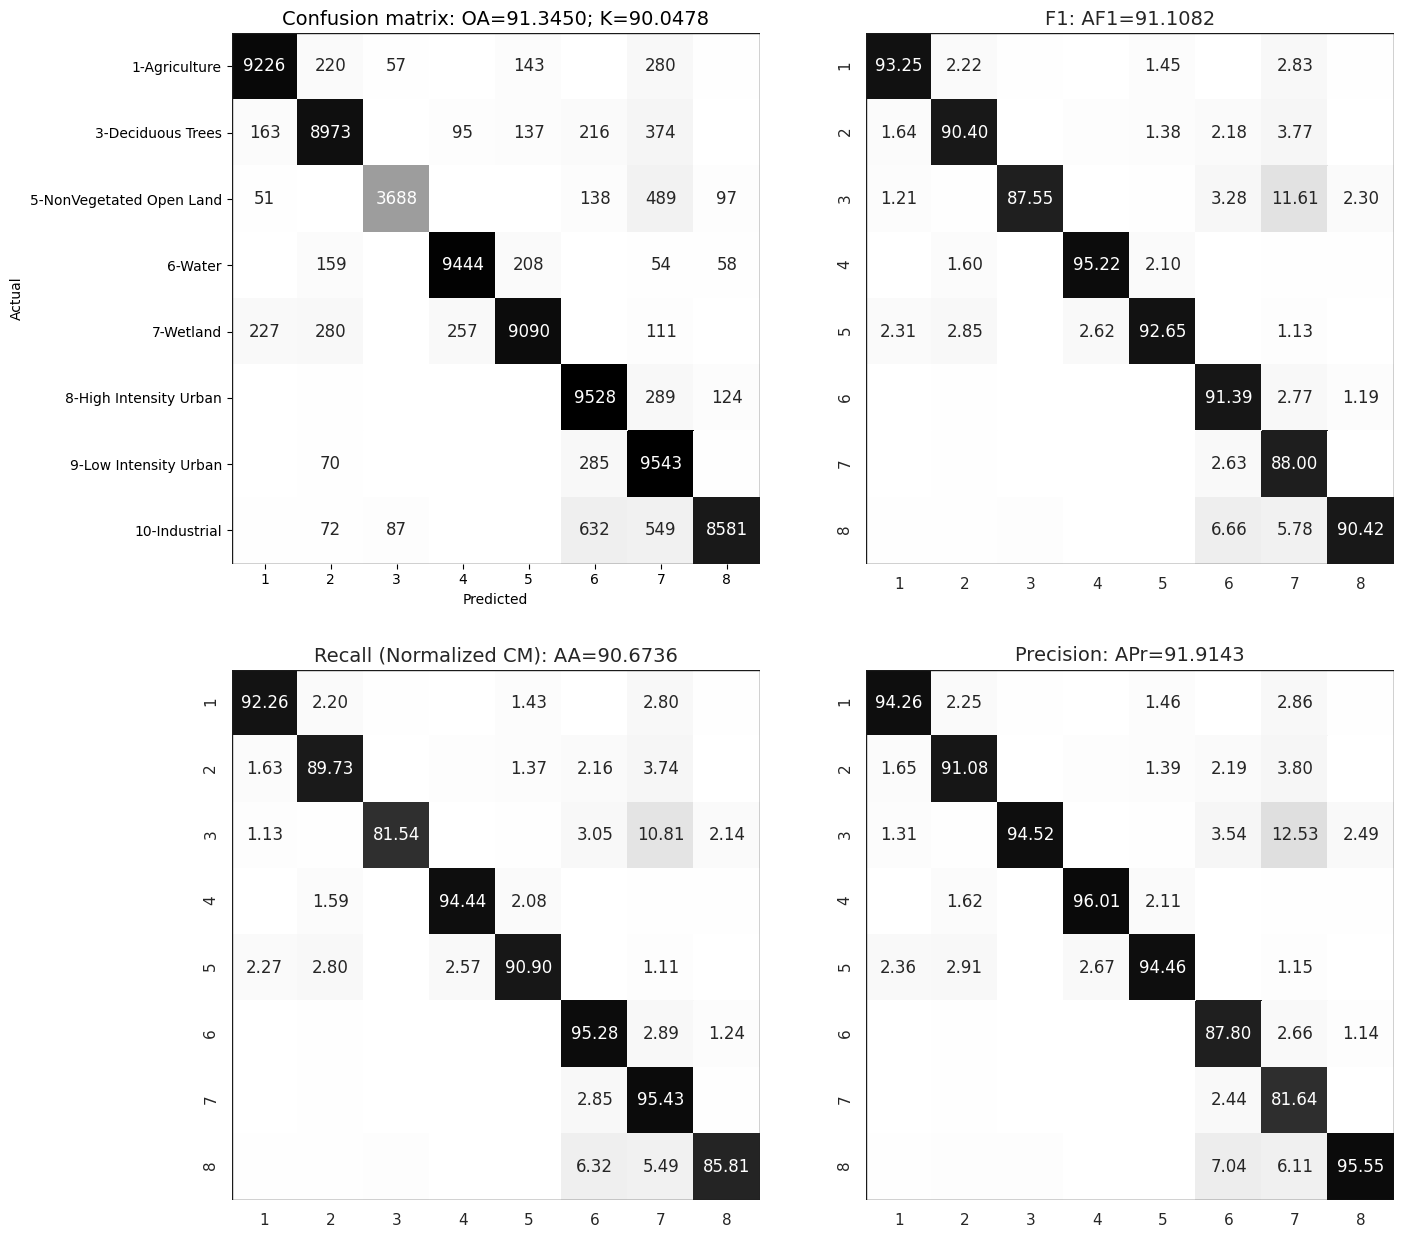

Data Evaluation:
              precision    recall  f1-score   support

           1       0.94      0.92      0.93     10000
           2       0.91      0.90      0.90     10000
           3       0.95      0.82      0.88      4523
           4       0.96      0.94      0.95     10000
           5       0.94      0.91      0.93     10000
           6       0.88      0.95      0.91     10000
           7       0.82      0.95      0.88     10000
           8       0.96      0.86      0.90     10000

    accuracy                           0.91     74523
   macro avg       0.92      0.91      0.91     74523
weighted avg       0.92      0.91      0.91     74523



,Results
OA,91.344954
Kappa,90.047797
BA,90.673600
Pr,91.914276
F1,91.108215


22528

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es_monitor = 'val_accuracy'
es = EarlyStopping(monitor=es_monitor, min_delta=0, mode='auto', verbose=1, patience=20, baseline=None, restore_best_weights=True)
batch = 64 
tf.random.set_seed(3)

def ModelDotFit( Tr_P, Val_P ):
  model = simple_CNN( input_shape=[ p,p,Tr_P.shape[-1] ] )
  model.compile( loss=loss, optimizer=nadam, metrics=['accuracy'] )
  Fit_Model = model.fit( Tr_P, tr_label_mlp, 
      validation_data =( Val_P, val_label_mlp[:len(Val_P)]), 
      epochs=epochs, verbose=1, batch_size=batch, callbacks=[es] )
  return model

def ModelPrediction(Val_inputs):
  val_predictions = np.zeros( np.shape(val_label_mlp) )
  for pp in range(100):
    start=pp*int( len(val_label)/100 ); stop=(pp+1)*int( len(val_label)/100 )
    # Patch gen
    P_ii = patchgen( Val_inputs, val_idx[start:stop], p=p )
    P_ii = np.transpose( P_ii, (0,2,3,1) )
    val_predictions[start:stop] = model.predict( P_ii )
    gc.collect()
  yval_pred = np.argmax(val_predictions,axis=1)+1# Validation Predictions
  return yval_pred

for scenario in SCENARIOS:
  print('Scenario: \n', scenario)

  if scenario == 1:
    # 1 - Just Sentinel temporal: 1-40
    model = ModelDotFit( train_P[:,:,:,:40],validation_P[:2000,:,:,:40] )
    yval_pred = ModelPrediction( fullstack[:,:,:40] )

  if scenario == 2:
    # 2 - Just Sentinel temporal & Pheno: 1-46
    model = ModelDotFit( train_P[:,:,:,:46],validation_P[:2000,:,:,:46] )
    yval_pred = ModelPrediction( fullstack[:,:,:46] )
  
  if scenario == 3:
    # 3 - Just Sentinel temporal & Topo: 1-40 & 47-49
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,46:49]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:2000,:,:,46:49]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2) )

  if scenario == 4:
    # 4 - Just Sentinel temporal & Veg: 1-40 & 49-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,49:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,49:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,49:]],axis=2) )
    
  if scenario == 5:
    # 5 - Just Sentinel temporal & Pheno & Topo: 1-49
    model = ModelDotFit( train_P[:,:,:,:49],validation_P[:2000,:,:,:49] )
    yval_pred = ModelPrediction( fullstack[:,:,:49] )
  
  if scenario == 6:
    # 6 - Just Sentinel temporal & Pheno & Veg: 1-46 & 49-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,49:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,49:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,49:]],axis=2) )
    
  if scenario == 7:
    # 7 - Just Sentinel temporal & Topo & Veg: 1-40 & 47-61
    model = ModelDotFit( np.concatenate([train_P[:,:,:,:40],train_P[:,:,:,46:]],axis=3),
                         np.concatenate([validation_P[:2000,:,:,:40],validation_P[:,:,:,46:]],axis=3) )
    yval_pred = ModelPrediction( np.concatenate([fullstack[:,:,:40],fullstack[:,:,46:]],axis=2) )

  if scenario == 8:
    # 8 - Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    model = ModelDotFit( train_P,validation_P[:2000,:,:,:] )
    yval_pred = ModelPrediction( fullstack )

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  # np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_SimpleCNN_Scenario '+str(scenario), CM_val)


gc.collect()
# mem()

Scenario: 
 16
Epoch 1/70
125/125 [==============================] - 32s 239ms/step - loss: 0.8169 - accuracy: 0.7559 - val_loss: 8.2742 - val_accuracy: 0.1768
Epoch 2/70
125/125 [==============================] - 30s 239ms/step - loss: 0.3620 - accuracy: 0.8789 - val_loss: 1.5892 - val_accuracy: 0.5791
Epoch 3/70
125/125 [==============================] - 30s 240ms/step - loss: 0.2675 - accuracy: 0.9103 - val_loss: 2.2485 - val_accuracy: 0.5171
Epoch 4/70
125/125 [==============================] - 30s 240ms/step - loss: 0.1938 - accuracy: 0.9342 - val_loss: 1.7698 - val_accuracy: 0.6445
Epoch 5/70
125/125 [==============================] - 30s 237ms/step - loss: 0.1567 - accuracy: 0.9474 - val_loss: 3.1864 - val_accuracy: 0.4917
Epoch 6/70
125/125 [==============================] - 30s 241ms/step - loss: 0.1396 - accuracy: 0.9535 - val_loss: 3.0565 - val_accuracy: 0.5039
Epoch 7/70
125/125 [==============================] - 30s 242ms/step - loss: 0.0921 - accuracy: 0.9721 - val_loss: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


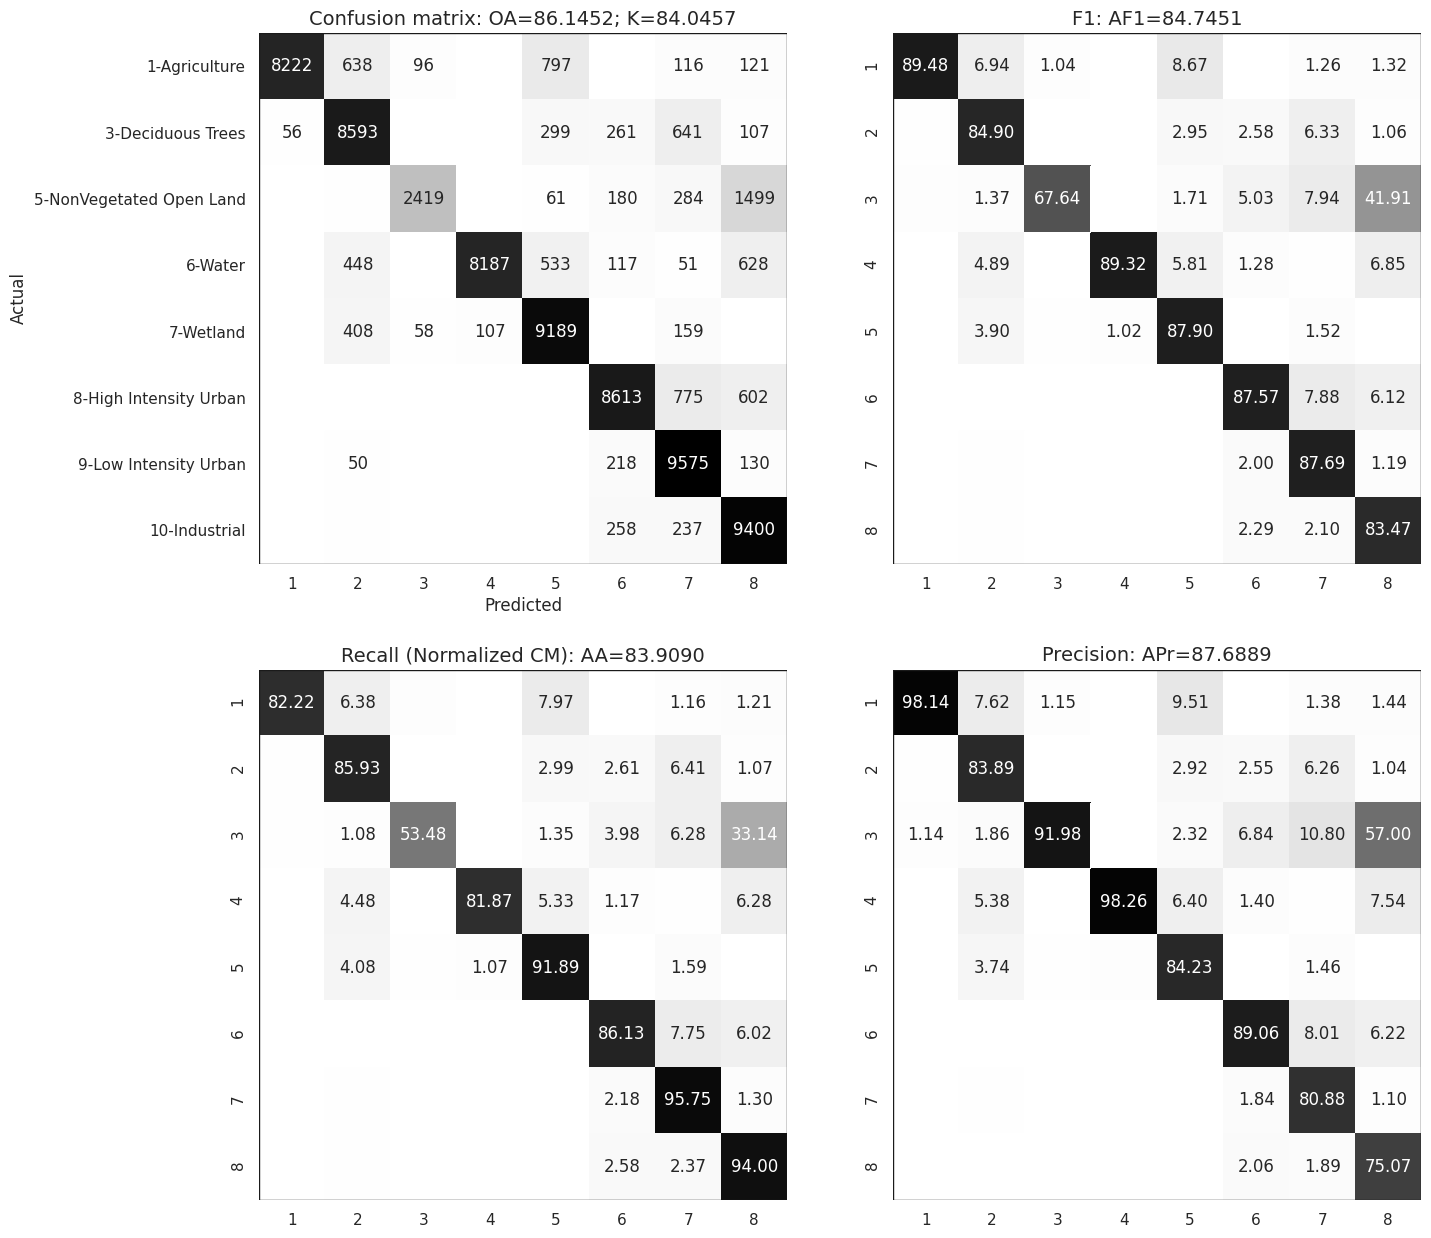

Data Evaluation:
              precision    recall  f1-score   support

           1       0.98      0.82      0.89     10000
           2       0.84      0.86      0.85     10000
           3       0.92      0.53      0.68      4523
           4       0.98      0.82      0.89     10000
           5       0.84      0.92      0.88     10000
           6       0.89      0.86      0.88     10000
           7       0.81      0.96      0.88     10000
           8       0.75      0.94      0.83     10000

    accuracy                           0.86     74523
   macro avg       0.88      0.84      0.85     74523
weighted avg       0.87      0.86      0.86     74523



,Results
OA,86.145217
Kappa,84.045748
BA,83.909025
Pr,87.688889
F1,84.745125


Used memory:  10169.8
Scenario: 
 17
Epoch 1/70
125/125 [==============================] - 33s 242ms/step - loss: 0.7453 - accuracy: 0.7785 - val_loss: 1.9583 - val_accuracy: 0.4639
Epoch 2/70
125/125 [==============================] - 30s 240ms/step - loss: 0.3483 - accuracy: 0.8851 - val_loss: 2.2037 - val_accuracy: 0.5645
Epoch 3/70
125/125 [==============================] - 30s 243ms/step - loss: 0.2592 - accuracy: 0.9161 - val_loss: 1.3655 - val_accuracy: 0.6465
Epoch 4/70
125/125 [==============================] - 31s 245ms/step - loss: 0.1978 - accuracy: 0.9349 - val_loss: 3.1741 - val_accuracy: 0.5264
Epoch 5/70
125/125 [==============================] - 31s 247ms/step - loss: 0.1450 - accuracy: 0.9513 - val_loss: 2.7960 - val_accuracy: 0.5444
Epoch 6/70
125/125 [==============================] - 30s 242ms/step - loss: 0.1161 - accuracy: 0.9621 - val_loss: 1.7647 - val_accuracy: 0.6577
Epoch 7/70
125/125 [==============================] - 30s 243ms/step - loss: 0.0821 - accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


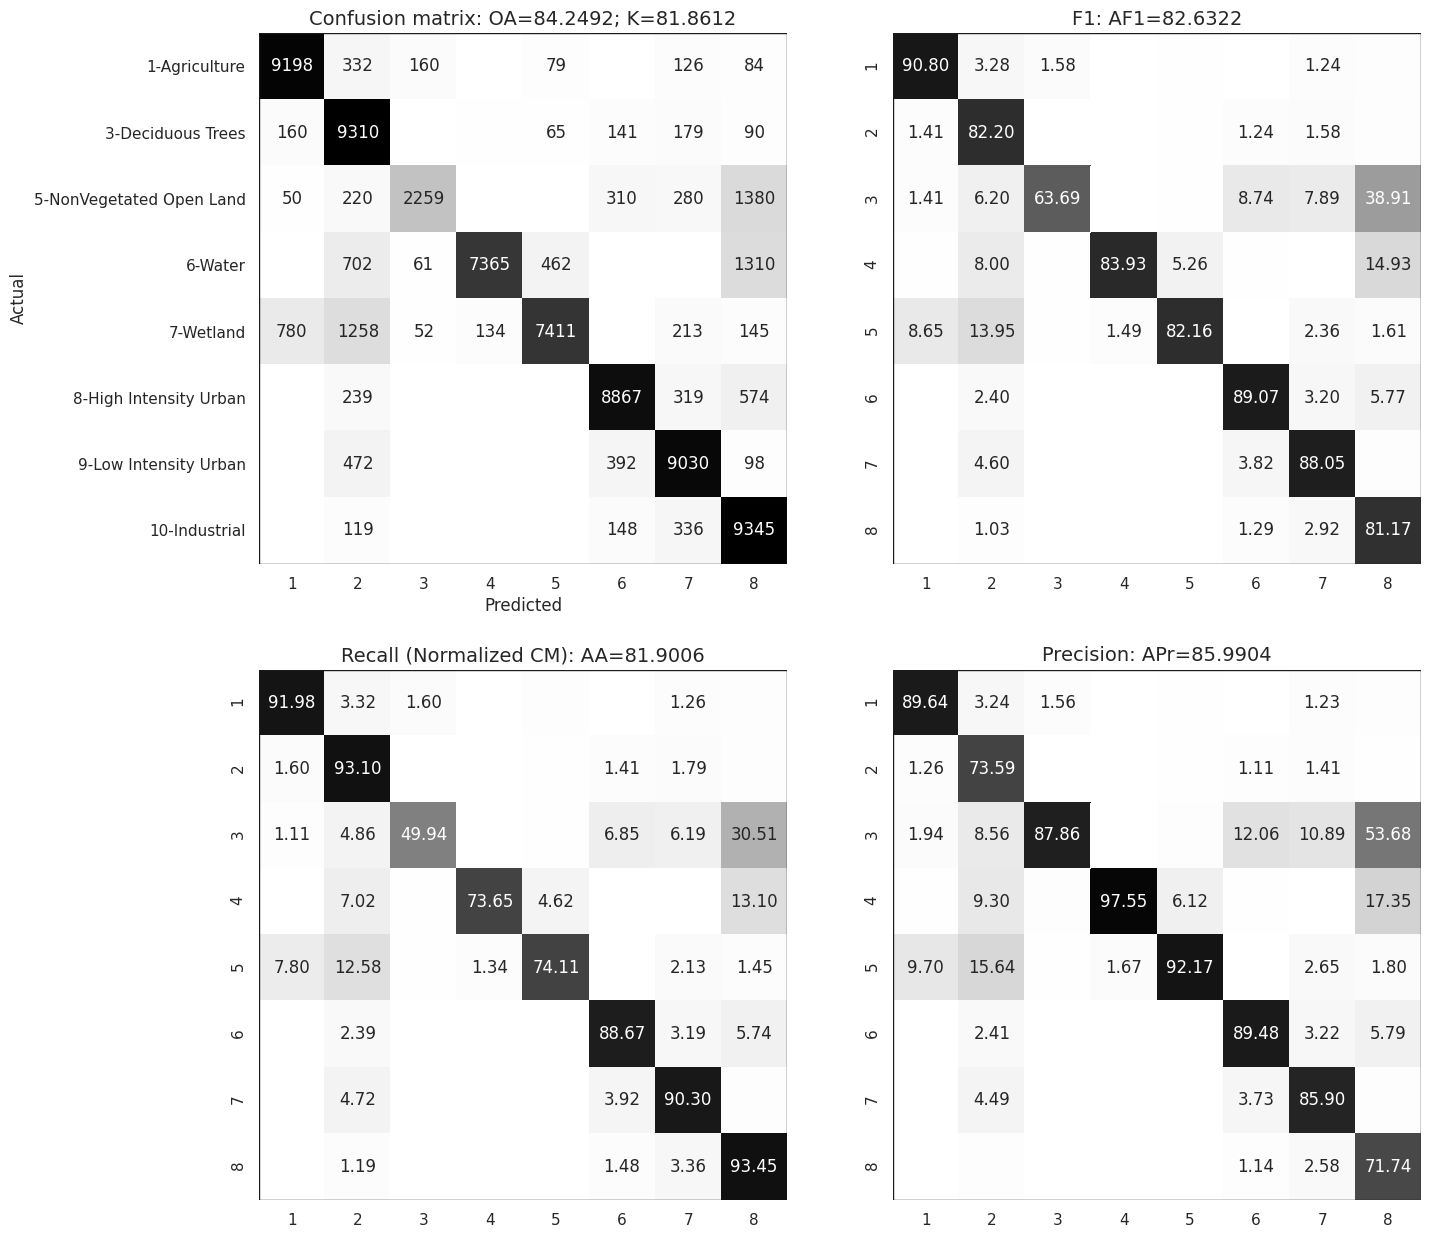

Data Evaluation:
              precision    recall  f1-score   support

           1       0.90      0.92      0.91     10000
           2       0.74      0.93      0.82     10000
           3       0.88      0.50      0.64      4523
           4       0.98      0.74      0.84     10000
           5       0.92      0.74      0.82     10000
           6       0.89      0.89      0.89     10000
           7       0.86      0.90      0.88     10000
           8       0.72      0.93      0.81     10000

    accuracy                           0.84     74523
   macro avg       0.86      0.82      0.83     74523
weighted avg       0.86      0.84      0.84     74523



,Results
OA,84.249158
Kappa,81.861156
BA,81.900591
Pr,85.990410
F1,82.632233


Used memory:  11644.3


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
es_monitor = 'val_accuracy'
es = EarlyStopping(monitor=es_monitor, min_delta=0, mode='auto', verbose=1, patience=15, baseline=None, restore_best_weights=True)
batch = 64
tf.random.set_seed(3)
epochs = 70
def ModelDotFit( training_batch_generator, validation_batch_generator, input_shape ):
  model = simple_CNN( input_shape=input_shape )
  model.compile( loss=loss, optimizer=nadam, metrics=['accuracy'] )
  Fit_Model = model.fit(
      training_batch_generator, steps_per_epoch = int( len(tr_idx) // batch),
      validation_data=validation_batch_generator, validation_steps = int( len(val_idx[:2048]) // batch ),
      epochs=epochs, verbose=1,  # batch_size=batch,
      callbacks=[es]
      )
  return model


for scenario in SCENARIOS:
  print('Scenario: \n', scenario)

  # GLCM Scenarios

  if scenario == 9:
    # 9 - Just GLCM
    training_batch_generator = Custom_BatchData_Generator( GLCM, p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( GLCM, p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( GLCM, p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 10:
    # 10 - GLCM + Multi-temporal and Spectral
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 11:
    # 11 - GLCM + Multi-temporal, Spectral, and Phenology
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+46 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1
   
  if scenario == 12:
    # 12 - GLCM + Multi-temporal, Spectral, and Topography
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+3 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1
 
  if scenario == 13:
    # 13 - GLCM + Multi-temporal, Spectral, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+12 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,49:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 14:
    # 14 - GLCM + Multi-temporal, Spectral, Phenology, and Topography
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+49 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:49]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 15:
    # 15 - GLCM + Multi-temporal, Spectral, Phenology, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+46+12 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:46],fullstack[:,:,49:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 16:
    # 16 - GLCM + Multi-temporal, Spectral, Topography, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    input_shape = [ p,p,80+40+15 ]
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack[:,:,:40],fullstack[:,:,46:]],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  if scenario == 17:
    input_shape = [ p,p,80+61 ]
    # 17 - GLCM + Multi-temporal, Spectral, Phenology, Topography, and Vegetation
    training_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, tr_idx, tr_label_mlp, batch )
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, val_idx[:2048], val_label_mlp[:2048], batch )
    #
    model = ModelDotFit( training_batch_generator,validation_batch_generator, input_shape )
    gc.collect()
    validation_batch_generator = Custom_BatchData_Generator( np.concatenate([GLCM,fullstack],axis=2), p, val_idx, val_label_mlp, batch )
    yval_pred = np.argmax( model.predict(validation_batch_generator),axis=1 )+1

  '''''''''''''''''''''''''''''''''''# Validation results'''''''''''''''''''''''''''''''''''

  axlabels = ['1-Agriculture','3-Deciduous Trees','5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

  CM_val = confusion_mat(val_label, yval_pred, axlabels=axlabels, plot=True,cmap="gray_r")
  np.save('/content/drive/MyDrive/LCLU-deep learning/Results/CM_Simple_CNN_Scenario '+str(scenario), CM_val)
  
  # Play an audio beep. Any audio URL will do.
  from google.colab import output
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  gc.collect()
  print('Used memory: ', mem())

# Full prediction map

Roads masked

In [ ]:
roads_map = 100*rasterio.open('/content/drive/MyDrive/LCLU-deep learning/trainingData/roads map/roads_map.tif').read(1) # label 100 for the roads

In [ ]:
roads_map_1d = np.int32( np.ravel(roads_map, order='F') ); roads_map_1d[roads_map_1d<1]=0

## Full classified map obtained by RF 

In [ ]:
te_idx = np.where(gt_1d0+roads_map_1d==0)[0]
test = fullstack_2d[te_idx]
# yte_pred = classifier_RF.predict(test)
yte_pred = classifier_RF.predict( np.hstack( [test, GLCM_2d[te_idx]] ) ) # Best scenario

classified_map = np.nan*np.zeros( dime[0]*dime[1] )
classified_map[te_idx] = yte_pred
classified_map[gt_1d0+roads_map_1d!=0]=np.nan
classified_map = np.reshape( classified_map, (dime[0], dime[1]), order='F' )
# zz = np.float32(np.reshape( gt_1d_test, (dime[0], dime[1]), order='F' ));zz[zz==0]=np.nan

In [ ]:
predmap_old = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_RF_best.tif').read(1)

predmap_new = predmap_old+np.uint8(classified_map)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


Cmaplist = [(1,1,1,1),(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),(213/255,238/255,178/255,1),
            (91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['','Agriculture','Deciduous Trees',#'Mixed Forest', 'Vegetated Open Land',
            'NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(predmap_new, cmap=cmap);plt.grid(False)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
# Save geotif
with rasterio.open(
        '/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_fullmap_RF_best.tif',
        'w',  # writing mode
        driver='GTiff',
        width=predmap_new.shape[1],
        height=predmap_new.shape[0],
        count=1,  # Bands
        dtype=np.uint8,
        nodata=0,
        transform=LC_io.transform,
        crs=LC_io.crs  # a coordinate reference system identifier or description
) as dst:
  dst.write( np.expand_dims(predmap_new, axis=0).astype(np.uint8) )

## Full classified map obtained by XG

In [ ]:
te_idx = np.where(gt_1d0+roads_map_1d==0)[0]
test = fullstack_2d[te_idx]

yte_pred = classifier_XG.predict( np.hstack( [test, GLCM_2d[te_idx]] ) ) # Best scenario

classified_map = np.nan*np.zeros( dime[0]*dime[1] )
classified_map[te_idx] = yte_pred
classified_map[gt_1d0+roads_map_1d!=0]=np.nan
classified_map = np.reshape( classified_map, (dime[0], dime[1]), order='F' )
# zz = np.float32(np.reshape( gt_1d_test, (dime[0], dime[1]), order='F' ));zz[zz==0]=np.nan

In [ ]:
predmap_old = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_XG_best.tif').read(1)

predmap_new = predmap_old+np.uint8(classified_map)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


Cmaplist = [(1,1,1,1),(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),(213/255,238/255,178/255,1),
            (91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['','Agriculture','Deciduous Trees',#'Mixed Forest', 'Vegetated Open Land',
            'NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(predmap_new, cmap=cmap);plt.grid(False)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
# Save geotif
with rasterio.open(
        '/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_fullmap_XG_best.tif',
        'w',  # writing mode
        driver='GTiff',
        width=predmap_new.shape[1],
        height=predmap_new.shape[0],
        count=1,  # Bands
        dtype=np.uint8,
        nodata=0,
        transform=LC_io.transform,
        crs=LC_io.crs  # a coordinate reference system identifier or description
) as dst:
  dst.write( np.expand_dims(predmap_new, axis=0).astype(np.uint8) )

## Full classified map obtained by SVM

In [ ]:
te_idx = np.where(gt_1d0+roads_map_1d==0)[0]
test = fullstack_2d[te_idx]

yte_pred = classifier_SVM.predict( np.hstack( [test[:,:40], test[:,46:49]] ) ) # Best scenario

classified_map = np.nan*np.zeros( dime[0]*dime[1] )
classified_map[te_idx] = yte_pred
classified_map[gt_1d0+roads_map_1d!=0]=np.nan
classified_map = np.reshape( classified_map, (dime[0], dime[1]), order='F' )

In [ ]:
predmap_old = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_SVM_best.tif').read(1)

predmap_new = predmap_old+np.uint8(classified_map)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


Cmaplist = [(1,1,1,1),(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),(213/255,238/255,178/255,1),
            (91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['','Agriculture','Deciduous Trees',#'Mixed Forest', 'Vegetated Open Land',
            'NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(predmap_new, cmap=cmap);plt.grid(False)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
# Save geotif
with rasterio.open(
        '/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_fullmap_SVM_best.tif',
        'w',  # writing mode
        driver='GTiff',
        width=predmap_new.shape[1],
        height=predmap_new.shape[0],
        count=1,  # Bands
        dtype=np.uint8,
        nodata=0,
        transform=LC_io.transform,
        crs=LC_io.crs  # a coordinate reference system identifier or description
) as dst:
  dst.write( np.expand_dims(predmap_new, axis=0).astype(np.uint8) )

## Full classified map obtained by CNN

In [ ]:
not_nan = np.where(gt_1d0+roads_map_1d==0)[0]

In [ ]:
m_batch = 1000

#load
# Restore the weights
model = simple_CNN( input_shape=[ p,p,43 ] )
weights_path = '/content/drive/MyDrive/LCLU-deep learning/Results/classified_map_Simple CNN_Scenario 3.h5'
model.load_weights(weights_path)

classified_map = 0*rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_Simple CNN_best.tif').read(1)

classified_map=np.ravel(classified_map,order='F');
gc.collect()
ii = int(len(np.where(classified_map!=0)[0])/m_batch) #-1

if ii<0:
  ii=0
ii

0

In [ ]:
for ii in range(ii, int(len(not_nan)/m_batch)+1 ):
  if ii%5==0:
    gc.collect()
  if ii%50==0:
    print(ii, '/', int(len(not_nan)/m_batch))
    print( mem() )
 
  if ii == int(len(not_nan)/m_batch):
    idxx = not_nan[m_batch*ii:]
  else:
    idxx = not_nan[ np.arange( m_batch*ii, m_batch*(ii+1), 1 ) ]
  
  # Patch gen
  P_ii = patchgen( np.concatenate([fullstack[:,:,:40],fullstack[:,:,46:49]],axis=2), idxx, p=p )
  P_ii = np.transpose( P_ii, (0,2,3,1) )
  
  # Prediction
  pred_probability = model.predict( P_ii )
  classified_map[idxx] = np.argmax(pred_probability,axis=1)+1

  # gc.collect()
  if mem()>12000:
    print('ii: ',ii)
    print( mem() )
    break

0 / 1291
1551.2
50 / 1291
4642.3
100 / 1291
4805.6
150 / 1291
4962.6
200 / 1291
6100.8
250 / 1291
6100.8
300 / 1291
6100.8
350 / 1291
6100.9
400 / 1291
6100.9
450 / 1291
6113.4
500 / 1291
6460.7
550 / 1291
6510.0
600 / 1291
6825.6
650 / 1291
7139.6
700 / 1291
7139.6
750 / 1291
7455.5
800 / 1291
7455.5
850 / 1291
7771.4
900 / 1291
7771.4
950 / 1291
8086.8
1000 / 1291
8323.8
1050 / 1291
8323.8
1100 / 1291
8535.9
1150 / 1291
8536.0
1200 / 1291
8851.8
1250 / 1291
8984.8


In [ ]:
classified_map=np.reshape(classified_map, LC.shape,order='F')
gc.collect()

1669

In [ ]:
predmap_old = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_Simple CNN_best.tif').read(1)

predmap_new = predmap_old+np.uint8(classified_map)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


Cmaplist = [(1,1,1,1),(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),(213/255,238/255,178/255,1),
            (91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['','Agriculture','Deciduous Trees',#'Mixed Forest', 'Vegetated Open Land',
            'NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(predmap_new, cmap=cmap);plt.grid(False)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
# Save geotif
with rasterio.open(
        '/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_fullmap_Simple CNN_best.tif',
        'w',  # writing mode
        driver='GTiff',
        width=predmap_new.shape[1],
        height=predmap_new.shape[0],
        count=1,  # Bands
        dtype=np.uint8,
        nodata=0,
        transform=LC_io.transform,
        crs=LC_io.crs  # a coordinate reference system identifier or description
) as dst:
  dst.write( np.expand_dims(predmap_new, axis=0).astype(np.uint8) )

## Full classified map obtained by ResNet

In [ ]:
not_nan = np.where(gt_1d0+roads_map_1d==0)[0]

In [ ]:
m_batch = 1000

#load
# Restore the weights
model = ResNet50_function( input_shape=[ p,p,40 ] )
weights_path = '/content/drive/MyDrive/LCLU-deep learning/Results/classified_map_ResNet50_Scenario 1.h5'
model.load_weights(weights_path)

classified_map = 0*rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_ResNet50_best.tif').read(1)

classified_map=np.ravel(classified_map,order='F');
gc.collect()
ii = int(len(np.where(classified_map!=0)[0])/m_batch) #-1

if ii<0:
  ii=0
ii

0

In [ ]:
for ii in range(ii, int(len(not_nan)/m_batch)+1 ):
  if ii%5==0:
    gc.collect()
  if ii%50==0:
    print(ii, '/', int(len(not_nan)/m_batch))
    print( mem() )
 
  if ii == int(len(not_nan)/m_batch):
    idxx = not_nan[m_batch*ii:]
  else:
    idxx = not_nan[ np.arange( m_batch*ii, m_batch*(ii+1), 1 ) ]
  
  # Patch gen
  P_ii = patchgen( fullstack[:,:,:40], idxx, p=p )
  P_ii = np.transpose( P_ii, (0,2,3,1) )
  
  # Prediction
  pred_probability = model.predict( P_ii )
  classified_map[idxx] = np.argmax(pred_probability,axis=1)+1

  # gc.collect()
  if mem()>12000:
    print('ii: ',ii)
    print( mem() )
    break

0 / 1291
9052.3
50 / 1291
9052.3
100 / 1291
9052.3
150 / 1291
9052.3
200 / 1291
9052.3
250 / 1291
9052.3
300 / 1291
9052.3
350 / 1291
9052.3
400 / 1291
9052.3
450 / 1291
9052.3
500 / 1291
9052.3
550 / 1291
9052.3
600 / 1291
9052.3
650 / 1291
9052.3
700 / 1291
9052.3
750 / 1291
9052.3
800 / 1291
9052.3
850 / 1291
9052.3
900 / 1291
9052.3
950 / 1291
9052.3
1000 / 1291
9052.3
1050 / 1291
9052.3
1100 / 1291
9052.3
1150 / 1291
9052.3
1200 / 1291
9052.3
1250 / 1291
9052.3


In [ ]:
classified_map=np.reshape(classified_map, LC.shape,order='F')
gc.collect()

2034

In [ ]:
predmap_old = rasterio.open('/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_map_ResNet50_best.tif').read(1)

predmap_new = predmap_old+np.uint8(classified_map)

In [ ]:
#
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch


Cmaplist = [(1,1,1,1),(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),(213/255,238/255,178/255,1),
            (91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
axlabels = ['','Agriculture','Deciduous Trees',#'Mixed Forest', 'Vegetated Open Land',
            'NonVegetated Open Land','Water','Wetland', 'High Intensity Urban', 'Low Intensity Urban', 'Industrial']

cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

plt.figure(figsize=(10,10),dpi=300)
plt.imshow(predmap_new, cmap=cmap);plt.grid(False)
plt.legend(handles=legend_patch, loc='upper left')
mem()

In [ ]:
# Save geotif
with rasterio.open(
        '/content/drive/MyDrive/LCLU-deep learning/Results/Maps/classified_fullmap_ResNet50_best.tif',
        'w',  # writing mode
        driver='GTiff',
        width=predmap_new.shape[1],
        height=predmap_new.shape[0],
        count=1,  # Bands
        dtype=np.uint8,
        nodata=0,
        transform=LC_io.transform,
        crs=LC_io.crs  # a coordinate reference system identifier or description
) as dst:
  dst.write( np.expand_dims(predmap_new, axis=0).astype(np.uint8) )

# Feature Importance
Open the Black-Box with SHAP algorithm

In [ ]:
axlabels = ['1-Agriculture','3-Deciduous Trees', '5-NonVegetated Open Land','6-Water','7-Wetland', '8-High Intensity Urban', '9-Low Intensity Urban', '10-Industrial']

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
# layers_name = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)

for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii]

import pandas as pd
train_df = pd.DataFrame(data=train,    # values
                # index=data[1:,0],    # 1st column as index
                columns=layers_name)  # 1st row as the column names

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Cmaplist = [(253/255,133/255,19/255,1),(1/255,58/255,11/255,1),(13/255,254/255,5/255,1),#(63/255,100/255,11/255,1),
            (213/255,238/255,178/255,1),(91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]
cmap=ListedColormap(Cmaplist)
legend_patch=[Patch(color=icolor,label=label) for icolor, label in zip(Cmaplist,axlabels)]

In [ ]:
train_df

,"1-""B2JAN""","2-""B3JAN""","3-""B4JAN""","4-""B5JAN""","5-""B6JAN""","6-""B7JAN""","7-""B8JAN""","8-""B11JAN""","9-""B12JAN""","10-""B8AJAN""","11-""B2MAR""","12-""B3MAR""","13-""B4MAR""","14-""B5MAR""","15-""B6MAR""","16-""B7MAR""","17-""B8MAR""","18-""B11MAR""","19-""B12MAR""","20-""B8AMAR""","21-""B2APR""","22-""B3APR""","23-""B4APR""","24-""B5APR""","25-""B6APR""","26-""B7APR""","27-""B8APR""","28-""B11APR""","29-""B12APR""","30-""B8AAPR""","31-""B2MAY""","32-""B3MAY""","33-""B4MAY""","34-""B5MAY""","35-""B6MAY""","36-""B7MAY""","37-""B8MAY""","38-""B11MAY""","39-""B12MAY""","40-""B8AMAY""","41-""EOS""","42-""LAR""","43-""LOS""","44-""MAX""","45-""SMA""","46-""SOS""","47-""ASP""","48-""DEM""","49-""SLOP""","50-""ndviJAN""","51-""ndviMAR""","52-""ndviAPR""","53-""ndviMAY""","54-""evi2JAN""","55-""evi2MAR""","56-""evi2APR""","57-""evi2MAY""","58-""ndreJAN""","59-""ndreMAR""","60-""ndreAPR""","61-""ndreMAY"""
0,0.013509,0.015616,0.026197,0.054248,0.086706,0.094881,0.085387,0.101534,0.061638,0.126891,0.011290,0.022542,0.035975,0.053260,0.074147,0.091744,0.104593,0.129734,0.085390,0.120580,0.017014,0.031435,0.035482,0.069452,0.114573,0.135815,0.183953,0.116535,0.067922,0.168400,0.013069,0.029336,0.018910,0.063097,0.219639,0.267231,0.264893,0.132921,0.061033,0.278554,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.786260,0.000000,0.755847,1.0,1.0,0.930650,0.563536,0.538411,0.672713,0.849233,0.574620,1.0,1.0,0.777320
1,0.024450,0.030414,0.046105,0.068103,0.091196,0.089547,0.080774,0.117200,0.082119,0.104165,0.034356,0.043828,0.059221,0.084040,0.087544,0.104877,0.093220,0.162692,0.125643,0.118518,0.032847,0.052278,0.057666,0.086359,0.121668,0.134321,0.133790,0.152362,0.105847,0.153400,0.017896,0.034052,0.022392,0.063219,0.211451,0.266852,0.290296,0.146858,0.080143,0.281105,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.465649,0.000000,0.624689,1.0,1.0,0.925429,0.409762,0.386896,0.478689,0.838911,0.530524,1.0,1.0,0.770182
2,0.012328,0.017091,0.020946,0.030588,0.028411,0.019899,0.017599,0.040692,0.025798,0.025465,0.009507,0.011242,0.015238,0.018420,0.010033,0.004748,0.010751,0.042524,0.027122,0.008684,0.008373,0.013952,0.017532,0.021833,0.007774,0.020416,0.026306,0.043832,0.027090,0.018466,0.022397,0.027207,0.032957,0.038005,0.033752,0.041782,0.062048,0.078096,0.059578,0.049550,0.0,0.0,0.0,0.0,0.0,0.0,0.253828,0.725191,0.142952,0.443986,1.0,1.0,0.640316,0.249863,0.220365,0.372322,0.426721,0.438817,1.0,1.0,0.466929
3,0.025529,0.028830,0.031218,0.066811,0.105858,0.122153,0.133633,0.102704,0.075358,0.122159,0.018096,0.028819,0.027071,0.057562,0.087667,0.104815,0.129203,0.121871,0.090009,0.110021,0.017389,0.033998,0.026299,0.074074,0.150605,0.161770,0.204922,0.123163,0.078824,0.180437,0.012961,0.031004,0.016809,0.071726,0.170948,0.202979,0.241395,0.144491,0.090326,0.228174,1.0,1.0,1.0,1.0,1.0,1.0,0.630386,0.625954,0.050578,0.802682,1.0,1.0,0.932242,0.629197,0.657114,0.755684,0.852400,0.572473,1.0,1.0,0.703605
4,0.017927,0.027192,0.033756,0.061058,0.096247,0.096739,0.102622,0.081318,0.046344,0.116431,0.015557,0.024140,0.023366,0.043686,0.068396,0.072508,0.096203,0.068864,0.040385,0.084156,0.013579,0.021583,0.023078,0.053640,0.083231,0.093365,0.122489,0.050459,0.027090,0.100712,0.025325,0.047455,0.030256,0.076071,0.169511,0.198056,0.244189,0.134894,0.068174,0.208979,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.435115,0.000000,0.742818,1.0,1.0,0.884869,0.546424,0.623004,0.677828,0.763050,0.571202,1.0,1.0,0.689185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,0.013818,0.015234,0.018234,0.023132,0.028692,0.029070,0.033256,0.035361,0.026848,0.029886,0.018312,0.018033,0.022111,0.027993,0.037196,0.032554,0.042011,0.056611,0.046390,0.040047,0.026889,0.034681,0.036854,0.050599,0.067683,0.079111,0.071886,0.079593,0.065808,0.086973,0.029826,0.043198,0.044123,0.067625,0.104569,0.

## SHAP

In [ ]:
# _=!pip install shap
# import shap

#### SHAP RF

In [ ]:
# Best Scenario

axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

# Just Correlation and Entropy
layers_name_GLCM = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name_GLCM = np.concatenate( [np.asanyarray(layers_name_GLCM)[::4],np.asanyarray(layers_name_GLCM)[1:][::4]] )
layers_name_GLCM = list(layers_name_GLCM)

layers_name += layers_name_GLCM
for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]

import pandas as pd
train_df = pd.DataFrame( data = np.hstack( [train, GLCM_2d[tr_idx]] ),    # values
                # index=data[1:,0],    # 1st column as index
                columns=layers_name )  # 1st row as the column names

In [ ]:
# Best Scenario

from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators=600)#,max_depth=60)
classifier_RF.fit( train_df, tr_label )

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
explainer_RF = shap.TreeExplainer(classifier_RF)
shap_values_RF = explainer_RF.shap_values( train_df[:1000] )
import pickle
with open("/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_values_RF.txt", "wb") as fp:   #Pickling
      pickle.dump(shap_values_RF, fp)

In [ ]:
'''
Bar chart of mean importance:
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
'''
import matplotlib
# shap.summary_plot(shap_values_RF, train_df[:2000], plot_type="bar", max_display = 20)#max_display = train.shape[1])


fig = plt.figure(dpi=600); plt.title('RF Feature importance')
shap.summary_plot(shap_values_RF, train_df[:2000], plot_type=None, color=None, axis_color='#333333', title='RF Feature importance', 
                  show=True, sort=True, color_bar=True, plot_size=(15,10), layered_violin_max_num_bins=10, 
                  class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                  cmap=matplotlib.colors.LinearSegmentedColormap)
fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_Feature importance_RF.jpeg', dpi=600)

#### SHAP XG

In [ ]:
# Best Scenario

axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

# Just Correlation and Entropy
layers_name_GLCM = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name_GLCM = np.concatenate( [np.asanyarray(layers_name_GLCM)[::4],np.asanyarray(layers_name_GLCM)[1:][::4]] )
layers_name_GLCM = list(layers_name_GLCM)

layers_name += layers_name_GLCM
for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]

import pandas as pd
train_df = pd.DataFrame( data = np.hstack( [train, GLCM_2d[tr_idx]] ),    # values
                # index=data[1:,0],    # 1st column as index
                columns=layers_name )  # 1st row as the column names

In [ ]:
# Best Scenario

from xgboost import XGBClassifier

classifier_XG = XGBClassifier(n_estimators=400)
classifier_XG.fit( train_df, tr_label)#, eval_metric='mlogloss', early_stopping_rounds=es )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
explainer_XG = shap.TreeExplainer(classifier_XG)
shap_values_XG = explainer_XG.shap_values( train_df[:1000] )
import pickle
with open("/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_values_XG.txt", "wb") as fp:   #Pickling
      pickle.dump(shap_values_XG, fp)

In [ ]:
'''
Bar chart of mean importance:
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
'''
import matplotlib
# shap.summary_plot(shap_values_XG, train_df[:2000], plot_type="bar", max_display = 20)#max_display = train.shape[1])


fig = plt.figure(dpi=600); plt.title('XG Feature importance')
shap.summary_plot(shap_values_XG, train_df[:2000], plot_type=None, color=None, axis_color='#333333', title='RF Feature importance', 
                  show=True, sort=True, color_bar=True, plot_size=(15,10), layered_violin_max_num_bins=10, 
                  class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                  cmap=matplotlib.colors.LinearSegmentedColormap)
fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_Feature importance_XG.jpeg', dpi=600)

#### SHAP SVM 

In [ ]:
_=! pip install alibi

In [ ]:
# Best Scenario

axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]

layers_name = layers_name[:40]+layers_name[46:49]

import pandas as pd
train_df = pd.DataFrame( data = np.hstack( [train[:,:40], train[:,46:49]] ),    # values
                # index=data[1:,0],    # 1st column as index
                columns=layers_name )  # 1st row as the column names

In [ ]:
# Best Scenario

from sklearn.svm import SVC

c = 316.22776601683796
gamma = 1.0
Kernel = 'rbf'
classifier_SVM = SVC( C=c, kernel=Kernel, gamma=gamma, decision_function_shape='ovr', max_iter=50000 )
classifier_SVM.fit( train_df, tr_label )

SVC(C=316.22776601683796, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=1.0, kernel='rbf',
    max_iter=50000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
''' Note that SVM classifier must be ovr! '''
from alibi.explainers import KernelShap
np.random.seed(0)
pred_fcn = classifier_SVM.decision_function
explainer_SVM = KernelShap(pred_fcn)
explainer_SVM.fit(train_df[:100])

KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': False,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [ ]:
explanation_SVM = explainer_SVM.explain( train_df[:100] , l1_reg=False)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# The SHAP values
import shap
shap_values_SVM = explanation_SVM.shap_values#( train_df[:100] )

import pickle
with open("/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_values_SVM.txt", "wb") as fp:   #Pickling
      pickle.dump(shap_values_SVM, fp)

In [ ]:
import matplotlib

fig = plt.figure(dpi=600); plt.title('SVM Feature importance')
shap.summary_plot(shap_values_SVM, train_df[:2000], plot_type=None, color=None, axis_color='#333333', 
                  show=True, sort=True, color_bar=True, plot_size=(15,10), layered_violin_max_num_bins=10, 
                  class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                  cmap=matplotlib.colors.LinearSegmentedColormap)


fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP_Feature importance_SVM.jpeg', dpi=600)

#### SHAP DL

In [ ]:
# 

axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)



In [ ]:
# _=!pip install shap
_=!pip install shap==0.36
import shap
shap.__version__

'0.36.0'

###### SHAP for Simple CNN

In [ ]:
#load Simple CNN Best Scenario
# Restore the weights
model = simple_CNN( input_shape=[ p,p,43 ] )
weights_path = '/content/drive/MyDrive/LCLU-deep learning/Results/classified_map_Simple CNN_Scenario 3.h5'
model.load_weights(weights_path)

layers_name = layers_name[:40]+layers_name[46:49] # Simple CNN Scenario
# layers_name = layers_name[:40] # ResNet Scenario
for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]

In [ ]:
# select a set of background examples to take an expectation over
random_choices = np.random.choice(train_P.shape[0], 200, replace=False) # random samples from the data
background = np.concatenate( [ train_P[random_choices,:,:,:40], train_P[random_choices,:,:,46:49] ],axis=-1 ) # Best scenario for Simple CNN
# background = train_P[random_choices]

# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, background)

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values( background )

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_values_CNN = []
for shsh in shap_values:
  shap_values_CNN.append( np.sum(shsh,axis=(1,2)) )

import pickle
with open("/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_Simple CNN.txt", "wb") as fp:   #Pickling
      pickle.dump(shap_values_CNN, fp)

In [ ]:
import matplotlib

fig = plt.figure(dpi=600); plt.title('Simple CNN Feature importance')
shap.summary_plot(shap_values_CNN, feature_names=layers_name, max_display=20, plot_type=None, color=None, axis_color='#333333', 
                  show=True, sort=True, color_bar=True, plot_size=(15,10), layered_violin_max_num_bins=20, 
                  class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                  cmap=matplotlib.colors.LinearSegmentedColormap)


fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Feature importance_Simple CNN.jpeg', dpi=600)

###### SHAP for ResNet50

In [ ]:
#load ResNet Best Scenario
# Restore the weights
model = ResNet50_function( input_shape=[ p,p,40 ] )
weights_path = '/content/drive/MyDrive/LCLU-deep learning/Results/classified_map_ResNet50_Scenario 1.h5'
model.load_weights(weights_path)

layers_name = layers_name[:40] # ResNet Scenario
for ii in range(len(layers_name)):
  layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]

gc.collect()

738

In [ ]:
# select a set of background examples to take an expectation over
random_choices = np.random.choice(train_P.shape[0], 200, replace=False) # random samples from the data
background = train_P[random_choices,:,:,:40] # Best scenario for ResNet


# since we have two inputs we pass a list of inputs to the explainer
explainer = shap.GradientExplainer(model, background)

# we explain the model's predictions on the first three samples of the test set
shap_values = explainer.shap_values( background )

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [ ]:
shap_values_CNN = []
for shsh in shap_values:
  shap_values_CNN.append( np.sum(shsh,axis=(1,2)) )

import pickle
with open("/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_ResNet.txt", "wb") as fp:   #Pickling
      pickle.dump(shap_values_CNN, fp)

In [ ]:
'''
Bar chart of mean importance:
This takes the average of the SHAP value magnitudes across the dataset and plots it as a simple bar chart.
'''
import matplotlib

fig = plt.figure(dpi=600); plt.title('ResNet Feature importance')
shap.summary_plot(shap_values_CNN, feature_names=layers_name, max_display=20, plot_type=None, color=None, axis_color='#333333', 
                  show=True, sort=True, color_bar=True, plot_size=(15,10), layered_violin_max_num_bins=20, 
                  class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                  cmap=matplotlib.colors.LinearSegmentedColormap)


fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Feature importance_ResNet.jpeg', dpi=600)

### SHAP results for the Manuscript

In [ ]:
_=!pip install shap
import shap

In [ ]:
axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

In [ ]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
Cmaplist = [(253/255,133/255,19/255,1),(13/255,254/255,5/255,1),(91/255,45/255,31/255,1),(3/255,20/255,176/255,1),(43/255,131/255,186/255,1), 
            (0,0,0,1),(100/255,100/255,100/255,1),(180/255,180/255,180/255,1)]

cmap=ListedColormap(Cmaplist)

In [ ]:
import numpy as np

layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

# Just Correlation and Entropy
layers_name_GLCM = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name_GLCM = np.concatenate( [np.asanyarray(layers_name_GLCM)[::4],np.asanyarray(layers_name_GLCM)[1:][::4]] )
layers_name_GLCM = list(layers_name_GLCM)

In [ ]:
# for ii in range(10):
#   layers_name[ii] = str(ii+1)+'-2017_'+layers_name[ii][1:-2]
#   layers_name[10+ii] = str(10+ii+1)+'-2018_'+layers_name[10+ii][1:-2]
#   layers_name[20+ii] = str(20+ii+1)+'-2019_'+layers_name[20+ii][1:-2]
#   layers_name[30+ii] = str(30+ii+1)+'-2020_'+layers_name[30+ii][1:-2]

for ii in range(0,len(layers_name)):
  # layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]
  layers_name[ii] = layers_name[ii][1:-1]
# layers_name

In [ ]:
for ii in range(len(layers_name_GLCM)):
    layers_name_GLCM[ii] = layers_name_GLCM[ii][1:-1]

In [ ]:
layers_name_all = layers_name+layers_name_GLCM

In [ ]:
shap_path = ['/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_RF.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_XG.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_SVM.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_Simple CNN.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_ResNet.txt']

layers_best = [layers_name_all,
          layers_name_all,
          layers_name_all[:41]+layers_name_all[46:49]+layers_name_all[41:46]
          ,layers_name_all[:41]+layers_name_all[46:49]+layers_name_all[41:46]
          ,layers_name_all[:41]+layers_name_all[41:46]
          ]

models_name = ['RF',
               'XG',
               'SVM',
               'Simple CNN',
               'ResNet']

In [ ]:
# import pickle
# import matplotlib
# # setting font sizeto 30
# plt.rcParams.update({'font.size': 42})
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# for shsh, ll, mm in zip(shap_path,layers_best, models_name):
#   with open(shsh, "rb") as fp:   #Unpickling
#       shap_model = pickle.load(fp)
  
#   fig = plt.figure(dpi=600); #plt.title('RF Feature importance')
  
#   shap.summary_plot(shap_model, feature_names=ll, max_display=20, plot_type=None, color=cmap, axis_color='#333333', 
#                     show=True, sort=True, color_bar=False, plot_size=(14,8), layered_violin_max_num_bins=20, 
#                     class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
#                     cmap=matplotlib.colors.LinearSegmentedColormap, use_log_scale=False)
#   # fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Feature importance_'+mm+'.jpeg', dpi=600)  

Normalized (Based on the Percentage of contribution of each feature)

In [ ]:
import pickle
import matplotlib
# setting font sizeto 30
plt.rcParams.update({'font.size': 70})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
import matplotlib 
matplotlib.rc('xtick', labelsize=60) 
# matplotlib.rc({'size': 40}) 
# matplotlib.rc('ytick', labelsize=20) 

for shsh, ll, mm in zip(shap_path,layers_best, models_name):
  with open(shsh, "rb") as fp:   #Unpickling
      shap_model = pickle.load(fp)
  
  shap_model2=np.asanyarray(shap_model)
  # shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=0), axis=0) # Wrong results!!
  shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=2), axis=2) # Percentage of contribution of a "feature" for a specific sample and label

  shap_model2_list = []
  for ii in range( len(shap_model) ):
    shap_model2_list.append( shap_model2[ii] )

  fig = plt.figure(dpi=400); #plt.title('RF Feature importance')
  
  shap.summary_plot(shap_model2_list, feature_names=ll, max_display=20, plot_type=None, color=cmap, axis_color='#333333', 
                    show=True, sort=True, color_bar=False, plot_size=(14,8), layered_violin_max_num_bins=20, 
                    class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                    cmap=matplotlib.colors.LinearSegmentedColormap, use_log_scale=False)
  fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Feature importance_Norm_'+mm+'.jpeg', dpi=600)  
  gc.collect()

In [ ]:
# import pickle
# import matplotlib
# # setting font sizeto 30
# plt.rcParams.update({'font.size': 10})
# plt.rcParams["font.family"] = "Times New Roman"

# for shsh, ll, mm in zip(shap_path,layers_best, models_name):
#   with open(shsh, "rb") as fp:   #Unpickling
#       shap_model = pickle.load(fp)
  
#   fig = plt.figure(dpi=600); #plt.title('RF Feature importance')
  
#   max_display=len(ll)
#   if shsh == shap_path[0]:
#     max_display=102
#   if shsh == shap_path[1]:
#     max_display=99
#   shap.summary_plot(shap_model, feature_names=ll, max_display=max_display, plot_type=None, color=cmap, axis_color='#333333', 
#                     show=True, sort=True, color_bar=False, plot_size=(14, int(len(ll)/4)), layered_violin_max_num_bins=30, 
#                     class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
#                     cmap=matplotlib.colors.LinearSegmentedColormap)
#   fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Full Feature importance_'+mm+'.jpeg', dpi=600)  

Normalized (Based on the Percentage of contribution of each feature)

In [ ]:
import pickle
import matplotlib
# setting font sizeto 30
plt.rcParams.update({'font.size': 38})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

for shsh, ll, mm in zip(shap_path,layers_best, models_name):
  with open(shsh, "rb") as fp:   #Unpickling
      shap_model = pickle.load(fp)
  
  shap_model2=np.asanyarray(shap_model)
  # shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=0), axis=0) # Wrong results!!
  shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=2), axis=2) # Percentage of contribution of a "feature" for a specific sample and label

  shap_model2_list = []
  for ii in range( len(shap_model) ):
    shap_model2_list.append( shap_model2[ii] )

  fig = plt.figure(dpi=600); #plt.title('RF Feature importance')
  
  max_display=len(ll)
  if shsh == shap_path[0]:
    max_display=102
  if shsh == shap_path[1]:
    max_display=99
  # if shsh == shap_path[2] or shsh == shap_path[3] or shsh == shap_path[4]: # add 5 dummy features!!
  #   for zz in range(8):
  #     shap_model2_list[zz] = np.concatenate( [shap_model2_list[zz],np.zeros([len(shap_model2_list[zz]),5])],axis=1 )
  
  shap.summary_plot(shap_model2_list, feature_names=ll, max_display=max_display, plot_type=None, color=cmap, axis_color='#333333', 
                    show=True, sort=True, color_bar=False, plot_size=(14, int(len(ll)/4)), layered_violin_max_num_bins=30, 
                    class_names=axlabels, color_bar_label='Feature value', class_inds=[0,1,2,3,4,5,6,7],
                    cmap=matplotlib.colors.LinearSegmentedColormap)
  fig.savefig('/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_Full Feature importance_Norm_'+mm+'.jpeg', dpi=600)  

# Most important feature for a class in a classifier for the Manuscript

In [ ]:
_=!pip install shap
import shap

In [ ]:
axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

In [ ]:
layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

# Just Correlation and Entropy
layers_name_GLCM = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name_GLCM = np.concatenate( [np.asanyarray(layers_name_GLCM)[::4],np.asanyarray(layers_name_GLCM)[1:][::4]] )
layers_name_GLCM = list(layers_name_GLCM)

In [ ]:
for ii in range(0,len(layers_name)):
  # layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]
  layers_name[ii] = layers_name[ii][1:-1]

In [ ]:
for ii in range(len(layers_name_GLCM)):
    layers_name_GLCM[ii] = layers_name_GLCM[ii][1:-1]

In [ ]:
layers_name_all = layers_name+layers_name_GLCM

In [ ]:
shap_path = ['/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_RF.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_XG.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_SVM.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_Simple CNN.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_ResNet.txt']

layers_best = [layers_name_all,
          layers_name_all,
          layers_name_all[:41]+layers_name_all[46:49],
          layers_name_all[:41]+layers_name_all[46:49],
          layers_name_all[:41]]

models_name = ['RF',
               'XG',
               'SVM',
               'Simple CNN',
               'ResNet']

In [ ]:
import pickle

shap_model = []
shap_model_norm = []
for shsh in shap_path:
  with open(shsh, "rb") as fp:   #Unpickling
      shap_model.append( pickle.load(fp) )  
      
      #
      #
      shap_model2=np.asanyarray(shap_model[-1])
      shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=2), axis=2) # Percentage of contribution of a "feature" for a specific sample and label

      shap_model2_list = []
      for ii in range( len(shap_model[-1]) ):
        shap_model2_list.append( shap_model2[ii] )
  shap_model_norm.append(shap_model2_list)

most_important = []
most_important2 = []
most_important_val = []
most_important_val2 = []
most_important_diffval = []
SHAP_algorithm = []
for alg_ii in range( len(shap_model) ):
  # print('Alg. idx: ', alg_ii)
  most_important.append([])
  most_important2.append([])
  most_important_val.append([])
  most_important_val2.append([])
  most_important_diffval.append([])
  for label_ii in range( len(axlabels) ):
    # print('Label. idx: ', label_ii)
    SHAP_algorithm.append( np.mean( np.abs(shap_model_norm[alg_ii][label_ii]),axis=0 ) )
    # m_i_ii = np.argmax( np.mean( np.abs(shap_model[alg_ii][label_ii]),axis=0 ) )
    # m_i_ii = np.argmax( np.mean( np.abs(shap_model_norm[alg_ii][label_ii]),axis=0 ) ) # Normalized SHAP
    
    m_i_ii = np.mean( np.abs(shap_model_norm[alg_ii][label_ii]),axis=0 ).argsort()[-1] # Normalized SHAP: Largest
    m_i_ii2 = np.mean( np.abs(shap_model_norm[alg_ii][label_ii]),axis=0 ).argsort()[-2] # Normalized SHAP: 2nd Largest
    
    most_important_val[-1].append( np.sort(np.mean(np.abs(shap_model_norm[alg_ii][label_ii]),axis=0))[-1] ) # Normalized SHAP: Largest value
    most_important_val2[-1].append( np.sort(np.mean(np.abs(shap_model_norm[alg_ii][label_ii]),axis=0))[-2] ) # Normalized SHAP: 2nd Largest value
    most_important_diffval[-1].append( np.sort(np.mean(np.abs(shap_model_norm[alg_ii][label_ii]),axis=0))[-1]-
                                      np.sort(np.mean(np.abs(shap_model_norm[alg_ii][label_ii]),axis=0))[-2] )

    layer_mi = layers_best[alg_ii][m_i_ii]
    most_important[-1].append(layer_mi)
    layer_mi2 = layers_best[alg_ii][m_i_ii2]
    most_important2[-1].append(layer_mi2)
    # print('Layer. idx: ', m_i_ii)

import pandas as pd
print('The largest contributions')
df = pd.DataFrame(data=most_important,    # values
                          index=models_name,    # 1st column as index
                          columns=axlabels)  # 1st row as the column names
display(df)
print('The 2nd largest contributions')
df = pd.DataFrame(data=most_important2,    # values
                          index=models_name,    # 1st column as index
                          columns=axlabels)  # 1st row as the column names
display(df)

print('The largest contributions (Values)')
df = pd.DataFrame(data=most_important_val,    # values
                          index=models_name,    # 1st column as index
                          columns=axlabels)  # 1st row as the column names
display(df)

print('The 2nd largest contributions (Values)')
df = pd.DataFrame(data=most_important_val2,    # values
                          index=models_name,    # 1st column as index
                          columns=axlabels)  # 1st row as the column names
display(df)

print('Difference between the 1st and 2nd largest contributions (Values)')
df = pd.DataFrame(data=most_important_diffval,    # values
                          index=models_name,    # 1st column as index
                          columns=axlabels)  # 1st row as the column names
display(df)

The largest contributions


,1-Agriculture,2-Deciduous Trees,3-NonVegetated Open Land,4-Water,5-Wetland,6-High Intensity Urban,7-Low Intensity Urban,8-Industrial
RF,B7MAY,evi2MAY,ndreMAY,B12MAY,DEM,B12MAY,ndreJAN,ndreMAY
XG,B7MAY,evi2MAY,ndreMAY,B12MAY,B12MAY,DEM,B12MAY,DEM
SVM,B7MAY,B8MAY,B12MAY,B12MAY,B12MAY,B11MAR,B11MAR,B8AMAY
Simple CNN,B7MAY,B8AMAY,EOS,B8MAY,B11MAY,B8AJAN,B8MAY,B11MAR
ResNet,B8AMAY,B8MAY,B11MAY,B8MAY,B12MAR,B6MAY,B11MAR,B12MAR


The 2nd largest contributions


,1-Agriculture,2-Deciduous Trees,3-NonVegetated Open Land,4-Water,5-Wetland,6-High Intensity Urban,7-Low Intensity Urban,8-Industrial
RF,B8AMAY,ndviMAY,B12MAY,B4MAY,B2MAYCOR,B2MAYCOR,B12MAY,ndviMAY
XG,evi2MAR,B12MAY,B12MAY,B8MAY,DEM,B11MAR,ndreJAN,ndreMAY
SVM,B12MAY,B12MAY,B8MAY,B11MAR,B12APR,B12APR,B12APR,B12MAY
Simple CNN,B8MAY,B8MAY,ASP,B7MAY,ASP,B8MAR,B8AMAY,B6MAY
ResNet,B8MAY,B8AMAY,B11JAN,B12MAR,B11JAN,B8MAR,B8AMAY,B2MAR


The largest contributions (Values)


,1-Agriculture,2-Deciduous Trees,3-NonVegetated Open Land,4-Water,5-Wetland,6-High Intensity Urban,7-Low Intensity Urban,8-Industrial
RF,0.042156,0.070798,0.069353,0.073472,0.057093,0.048936,0.047408,0.056342
XG,0.088158,0.104952,0.098945,0.201549,0.107125,0.140703,0.066258,0.089065
SVM,0.097145,0.093631,0.114218,0.147633,0.087053,0.117252,0.081696,0.094671
Simple CNN,0.091045,0.068376,0.065920,0.086248,0.061323,0.066449,0.061686,0.052653
ResNet,0.081072,0.058308,0.053374,0.066488,0.070018,0.064671,0.061331,0.053827


The 2nd largest contributions (Values)


,1-Agriculture,2-Deciduous Trees,3-NonVegetated Open Land,4-Water,5-Wetland,6-High Intensity Urban,7-Low Intensity Urban,8-Industrial
RF,0.038727,0.061470,0.058771,0.062115,0.038333,0.039331,0.042806,0.053431
XG,0.059410,0.060043,0.073399,0.095241,0.075012,0.064308,0.060282,0.068426
SVM,0.094678,0.058733,0.066844,0.087168,0.069904,0.081161,0.068202,0.062466
Simple CNN,0.090558,0.067435,0.051069,0.064527,0.047677,0.062008,0.056602,0.050886
ResNet,0.066402,0.053290,0.052289,0.064376,0.060693,0.061240,0.056998,0.046672


Difference between the 1st and 2nd largest contributions (Values)


,1-Agriculture,2-Deciduous Trees,3-NonVegetated Open Land,4-Water,5-Wetland,6-High Intensity Urban,7-Low Intensity Urban,8-Industrial
RF,0.003430,0.009328,0.010581,0.011358,0.018760,0.009605,0.004602,0.002911
XG,0.028748,0.044909,0.025547,0.106308,0.032113,0.076394,0.005976,0.020639
SVM,0.002467,0.034898,0.047374,0.060464,0.017148,0.036090,0.013495,0.032205
Simple CNN,0.000487,0.000940,0.014851,0.021721,0.013646,0.004442,0.005084,0.001767
ResNet,0.014670,0.005018,0.001085,0.002112,0.009325,0.003431,0.004333,0.007155


# Overall feature contributions

In [ ]:
axlabels = ['1-Agriculture','2-Deciduous Trees', '3-NonVegetated Open Land','4-Water','5-Wetland', '6-High Intensity Urban', '7-Low Intensity Urban', '8-Industrial']

In [ ]:
layers_name = np.loadtxt("/content/drive/MyDrive/LCLU-deep learning/trainingData/fullStack/T33UUB.txt", delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name = list(layers_name)

# Just Correlation and Entropy
layers_name_GLCM = np.loadtxt('/content/drive/MyDrive/LCLU-deep learning/trainingData/individualStacks/GLCM.txt', delimiter="\n",comments='str', dtype = '<U128',unpack=False)
layers_name_GLCM = np.concatenate( [np.asanyarray(layers_name_GLCM)[::4],np.asanyarray(layers_name_GLCM)[1:][::4]] )
layers_name_GLCM = list(layers_name_GLCM)

In [ ]:
for ii in range(0,len(layers_name)):
  # layers_name[ii] = str(ii+1)+'-'+layers_name[ii][1:-2]
  layers_name[ii] = layers_name[ii][1:-1]

In [ ]:
for ii in range(len(layers_name_GLCM)):
    layers_name_GLCM[ii] = layers_name_GLCM[ii][1:-1]

In [ ]:
layers_name_all = layers_name+layers_name_GLCM

In [ ]:
shap_path = ['/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_RF.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_XG.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_SVM.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_Simple CNN.txt',
             '/content/drive/MyDrive/LCLU-deep learning/Results/SHAP/SHAP_values_ResNet.txt']

layers_best = [layers_name_all,
          layers_name_all,
          layers_name_all[:41]+layers_name_all[46:49],
          layers_name_all[:41]+layers_name_all[46:49],
          layers_name_all[:41]]

models_name = ['RF',
               'XG',
               'SVM',
               'Simple CNN',
               'ResNet']

In [ ]:
import pickle

shap_model_array = []
for shsh, ll, mm in zip(shap_path,layers_best, models_name):
  with open(shsh, "rb") as fp:   #Unpickling
      shap_model=pickle.load(fp)

  shap_model2=np.asanyarray(shap_model)
  # shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=0), axis=0) # Wrong results!!
  shap_model2/=np.expand_dims(np.sum(np.abs(shap_model2), axis=2), axis=2) # Percentage of contribution of a "feature" for a specific sample and label

  shap_model_array.append(shap_model2)
   

  shap_model2_list = []
  for ii in range( len(shap_model) ):
    shap_model2_list.append( shap_model2[ii] )


In [ ]:
shap_model_array141 = np.zeros( [8,141] )
for ii in shap_model_array:
  shap_model_array_ii = np.mean( np.abs(ii),axis=1 )
  shap_model_array141[ :, :np.shape(shap_model_array_ii)[1] ] += shap_model_array_ii

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams.update({'font.size': 20})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

for cc in range(len(axlabels)):

  fig, ax = plt.subplots(figsize=(36,3), dpi=300)
  ax.set_title(axlabels[cc][2:],{'fontsize': 35})
  ax.set_xlabel('Features',{'fontsize': 25})
  ax.set_ylabel('Contribution score',{'fontsize': 25})
  ax.set_ylim([0,0.55])
  ax.set_xlim([-1,101])

  y_pos = range(101)
  ax.bar( y_pos,shap_model_array141[cc,:101] )
  _=plt.xticks(y_pos, layers_name_all, rotation=90)
  for ii in range(40): # S2
    ax.get_xticklabels()[ii].set_color("red")
    ax.get_children()[ii].set_color('red') 
  for ii in range(40,46): # Pheno
    ax.get_xticklabels()[ii].set_color("navy")
    ax.get_children()[ii].set_color('navy') 
  for ii in range(46,49): # Topo
    ax.get_xticklabels()[ii].set_color("sienna")
    ax.get_children()[ii].set_color('sienna') 
  for ii in range(49,61): # Veg
    ax.get_xticklabels()[ii].set_color("green")
    ax.get_children()[ii].set_color('green') 
  for ii in range(61,101): # GLCM
    ax.get_xticklabels()[ii].set_color("black")
    ax.get_children()[ii].set_color('black') 

In [ ]:
# subplots sharing both x/y axes
f, ax = plt.subplots(8, figsize=(18,12), dpi=300, sharex=True, sharey=True)
plt.rcParams.update({'font.size': 10})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

cc = 0
for ax_i in ax:
  y_pos = range(101)
  ax_i.bar( y_pos,shap_model_array141[cc,:101] )

  ax_i.set_title(axlabels[cc][2:],{'fontsize': 12}, y=0.7)#, x=0.8, y=0.5)
  if cc == 3:
    ax_i.set_ylabel('Contribution score',{'fontsize': 20})
  ax_i.set_ylim([0,0.6])
  ax_i.set_xlim([-1,101])
  ax_i.set_yticks([0, 0.5]) # Grid

  # ax_i.spines['right'].set_visible(False)
  # ax_i.spines['top'].set_visible(False)

  _=plt.xticks(y_pos, layers_name_all, rotation=90)
  for ii in range(40): # S2
    # ax_i.get_xticklabels()[ii].set_color("red")
    ax_i.get_children()[ii].set_color('red') 
  for ii in range(40,46): # Pheno
    # ax_i.get_xticklabels()[ii].set_color("navy")
    ax_i.get_children()[ii].set_color('navy') 
  for ii in range(46,49): # Topo
    # ax_i.get_xticklabels()[ii].set_color("sienna")
    ax_i.get_children()[ii].set_color('sienna') 
  for ii in range(49,61): # Veg
    # ax_i.get_xticklabels()[ii].set_color("green")
    ax_i.get_children()[ii].set_color('green') 
  for ii in range(61,101): # GLCM
    # ax_i.get_xticklabels()[ii].set_color("black")
    ax_i.get_children()[ii].set_color('black') 
  cc+=1

# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0.0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
ax_i.set_xlabel('Features',{'fontsize': 20})
for ii in range(40): # S2
  ax_i.get_xticklabels()[ii].set_color("red")
  ax_i.get_children()[ii].set_color('red') 
for ii in range(40,46): # Pheno
  ax_i.get_xticklabels()[ii].set_color("navy")
  ax_i.get_children()[ii].set_color('navy') 
for ii in range(46,49): # Topo
  ax_i.get_xticklabels()[ii].set_color("sienna")
  ax_i.get_children()[ii].set_color('sienna') 
for ii in range(49,61): # Veg
  ax_i.get_xticklabels()[ii].set_color("green")
  ax_i.get_children()[ii].set_color('green') 
for ii in range(61,101): # GLCM
  ax_i.get_xticklabels()[ii].set_color("black")
  ax_i.get_children()[ii].set_color('black') 
plt.savefig( '/content/drive/MyDrive/LCLU-deep learning/Results/overall feature contributions per class.jpg', dpi = 600 )